In [1]:
import os
import glob
import scipy.io as sio
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import itertools
from os import path
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from random import sample
import warnings
warnings.filterwarnings('ignore')

In [2]:
from analysis_functions import *
from plotting_functions import *
from constant_variables import *

# Setup

In [3]:
####### RUNNING OPTIONS #######
monkey = 'Stanton'

exclude_stim1 = False # exclude first stimulus per trial for passive viewing

run_processing = True
run_tuning_curves = True
run_processing = True

In [4]:
# PATHS
datapath = 'E:\\two_boundary\\original_data\\'
figpath = 'E:\\two_boundary\\figures\\passive_viewing\\'
datapathsave = 'E:\\two_boundary\\data_pv\\'

# BRAIN AREAS
brain_areas = ['MT', 'MST', 'LIP', 'SC']

#if monkey == 'Neville':
#    brain_areas = ['MT', 'MST', 'LIP']
#else:
#    brain_areas = ['MST', 'LIP']

# BINNING/SMOOTHING PARAMETERS
bin_size = 100 # msec for binned data

# MIN NUM TRIALS FOR INCLUSION
min_ntrials = 5

# Time windows for analysis
windows = [np.arange(-100, 401), np.arange(-500, 1)]
#windows = [np.arange(-100, 401)]

### Decoder analysis parameters

In [5]:
n_trials_cat = 20 # per dir, so per cat = 60
n_trials_dir = 12 # per dir

window = windows[0]
window_name = 'window_' + str(window[0]) + '_' + str(window[-1])

### Sliding window decoder
n_iter_sw = 200

### Epoch decoder
n_iter_ep = 200
n_perms = 5000

epoch_windows_cat, epoch_windows_dir = {}, {}

for area in brain_areas:
    epoch_windows_cat[area] = [300, 400]

epoch_windows_dir = {'MT':[100, 300], 'MST': [100, 300], 'LIP': [200, 400]}

# Data processing

In [6]:
if run_processing:
    for area in brain_areas[3:4]:
        for window in windows[0:1]:

            currpath = datapath + monkey + '\\' + area
            os.chdir(currpath)

            filelist = [f for f in glob.glob("*_merged_w_ratings.mat")]
            savepath = datapathsave + monkey + '\\' + area + '\\'

            for fname in filelist:
                passive_viewing_analysis_main(fname, window, bin_size, savepath, area, monkey, exclude_stim1, min_ntrials)

# Tuning curves

In [2144]:
indx1 = np.where(window >= 100)[0][0]
indx2 = np.where(window >= 400)[0][0]  

for area in brain_areas[3:]:
    if exclude_stim1:  
        currpath = datapathsave + monkey + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
    else:
        currpath = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'

    tuningcurve_figpath = figpath + '\\tuning_curves\\' + monkey + '\\' + area + '\\'
    make_dirs(tuningcurve_figpath)
            
    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]    

    corr_all = []   
    
    for file in filelist:
        data = sio.loadmat(file)
        neuron_name = file[0:-4]

        window_mean_pv = np.hstack([np.mean(np.mean(data['spikes_binned_pv'].flatten()[i][:, indx1:indx2], 1))*10 for i in range(N_DIRS)])
        window_mean_dmc = np.hstack([np.mean(np.mean(data['spikes_binned_dmc'].flatten()[i][:, indx1:indx2], 1))*10 for i in range(N_DIRS)])

        window_sem_pv = np.hstack([sp.stats.sem(np.mean(data['spikes_binned_pv'].flatten()[i][:, indx1:indx2], 1))*10  for i in range(N_DIRS)])
        window_sem_dmc = np.hstack([sp.stats.sem(np.mean(data['spikes_binned_dmc'].flatten()[i][:, indx1:indx2], 1))*10  for i in range(N_DIRS)])

        # Plot tuning curve
        plot_pv_tuning_curve(window_mean_dmc, window_mean_pv, window_sem_dmc, window_sem_pv, neuron_name, tuningcurve_figpath)

In [7]:
    for window in windows[2:]:
        window_name = 'window_' + str(window[0]) + '_' + str(window[-1])

        for area in brain_areas:
            if exclude_stim1:  
                currpath = datapathsave + monkey + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
            else:
                currpath = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'

            tuningcurve_figpath = figpath + '\\tuning_curves\\' + monkey + '\\' + area + '\\' + window_name + '\\'
            make_dirs(tuningcurve_figpath)

            os.chdir(currpath)
            filelist = [f for f in glob.glob("*.mat")]    

            for file in filelist:
                data = sio.loadmat(file)
                neuron_name = file[0:-4]

                window_mean_pv = data['window_mean_pv'].flatten()
                window_mean_dmc = data['window_mean_dmc'].flatten()
                window_sem_pv = data['window_sem_pv'].flatten()
                window_sem_dmc = data['window_sem_dmc'].flatten()       

                # Plot tuning curve
                plot_pv_tuning_curve(window_mean_dmc, window_mean_pv, window_sem_dmc, window_sem_pv, neuron_name, tuningcurve_figpath)

# Decoding

## Sliding window

In [7]:
cat_svm_perf = {}
dir_svm_perf = {}

window = windows[0]
window_name = 'window_' + str(window[0]) + '_' + str(window[-1])
timepoints = np.arange(0, len(window))

for area in brain_areas[3:]:
    
    if monkey != 'both':
        if exclude_stim1:  
            currpath = datapathsave + monkey + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
        else:
            currpath = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'

        os.chdir(currpath)
        filelist = [f for f in glob.glob("*.mat")]  
    else:
        if exclude_stim1:  
            currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
            currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
        else:
            currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_included\\' + window_name + '\\'
            currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_included\\' + window_name + '\\'

        os.chdir(currpath1)
        filelist1 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        os.chdir(currpath2)
        filelist2 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        
        filelist = np.hstack([filelist1, filelist2])
        
    n_neurons_decoder = len(filelist)

    spikes_all = {}
    spikes_all['PV'], spikes_all['DMC'] = [], []
    cat_perf_all = {}
    dir_perf_all = {}

    for file in filelist:
        data = sio.loadmat(file)
        spikes_all['PV'].append(data['spikes_binned_pv'].flatten())
        spikes_all['DMC'].append(data['spikes_binned_dmc'].flatten())
        
    for task in tasks:
        cat_perf_all[task] = category_decoder(spikes_all[task], n_iter_sw, timepoints, n_neurons_decoder, n_neurons_decoder, n_trials_cat)    
        dir_perf_all[task] = direction_decoder(spikes_all[task], n_iter_sw, timepoints, n_neurons_decoder, n_neurons_decoder, n_trials_dir)    
    
    cat_svm_perf[area] = cat_perf_all
    dir_svm_perf[area] = dir_perf_all
    
#sp.io.savemat(datapathsave + monkey + '_cat_decoder_sliding_window.mat', {'cat_decoder_mean_all': cat_svm_perf}) 
#sp.io.savemat(datapathsave + monkey + '_dir_decoder_sliding_window.mat', {'dir_decoder_mean_all': dir_svm_perf})   

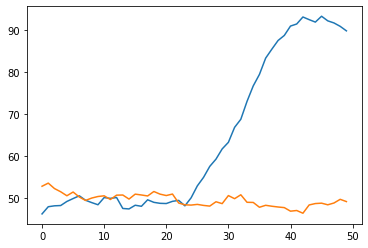

In [8]:
plt.plot(np.mean(cat_svm_perf[area]['DMC'], 0))
plt.plot(np.mean(cat_svm_perf[area]['PV'], 0))

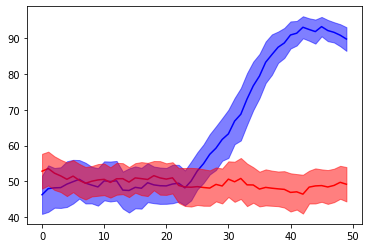

In [9]:
currmean = np.mean(cat_svm_perf[area]['DMC'], 0)
currstd = np.std(cat_svm_perf[area]['DMC'], 0)
plt.plot(np.mean(cat_svm_perf[area]['DMC'], 0), 'b')
plt.fill_between(range(len(currmean)), currmean-currstd, currmean+currstd,  lw = 1., alpha = 0.5, zorder=20, color = 'b')

currmean = np.mean(cat_svm_perf[area]['PV'], 0)
currstd = np.std(cat_svm_perf[area]['PV'], 0)
plt.plot(np.mean(cat_svm_perf[area]['PV'], 0), 'r')
plt.fill_between(range(len(currmean)), currmean-currstd, currmean+currstd,  lw = 1., alpha = 0.5, zorder=20, color = 'r')


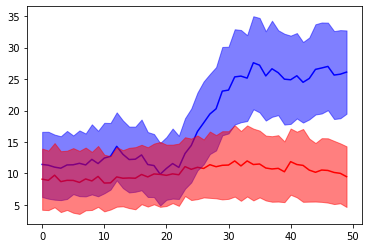

In [10]:
currmean = np.mean(dir_svm_perf[area]['DMC'], 0)
currstd = np.std(dir_svm_perf[area]['DMC'], 0)
plt.plot(np.mean(dir_svm_perf[area]['DMC'], 0), 'b')
plt.fill_between(range(len(currmean)), currmean-currstd, currmean+currstd,  lw = 1., alpha = 0.5, zorder=20, color = 'b')

currmean = np.mean(dir_svm_perf[area]['PV'], 0)
currstd = np.std(dir_svm_perf[area]['PV'], 0)
plt.plot(np.mean(dir_svm_perf[area]['PV'], 0), 'r')
plt.fill_between(range(len(currmean)), currmean-currstd, currmean+currstd,  lw = 1., alpha = 0.5, zorder=20, color = 'r')


In [ ]:
plt.plot()

### Plot category decoder

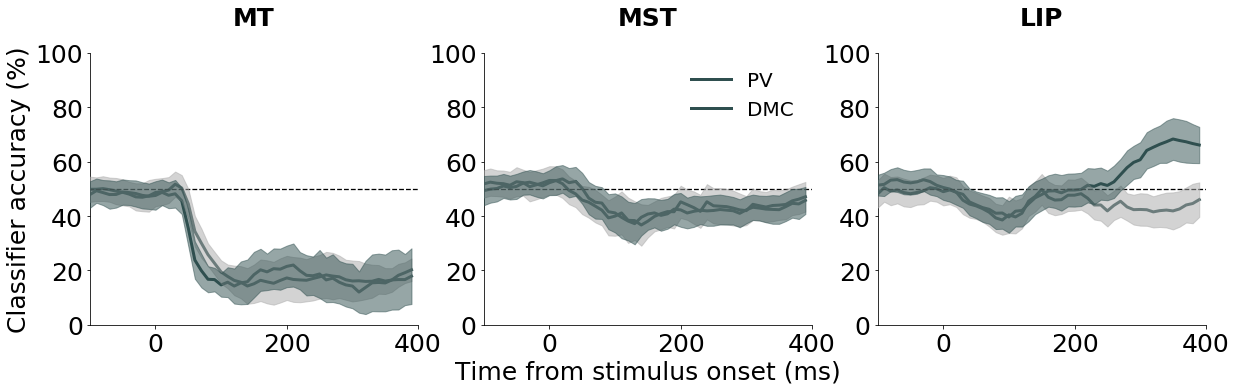

In [465]:
ylim = [0, 100]
chance_level = 50
if exclude_stim1:  
    savepath = figpath + monkey + '_category_decoder_sliding_window_trial1_excl.'
else:
    savepath = figpath + monkey + '_category_decoder_sliding_window.'

plot_pv_decoder(cat_svm_perf, ylim, chance_level, savepath, brain_areas, save = True)

### Plot direction decoder

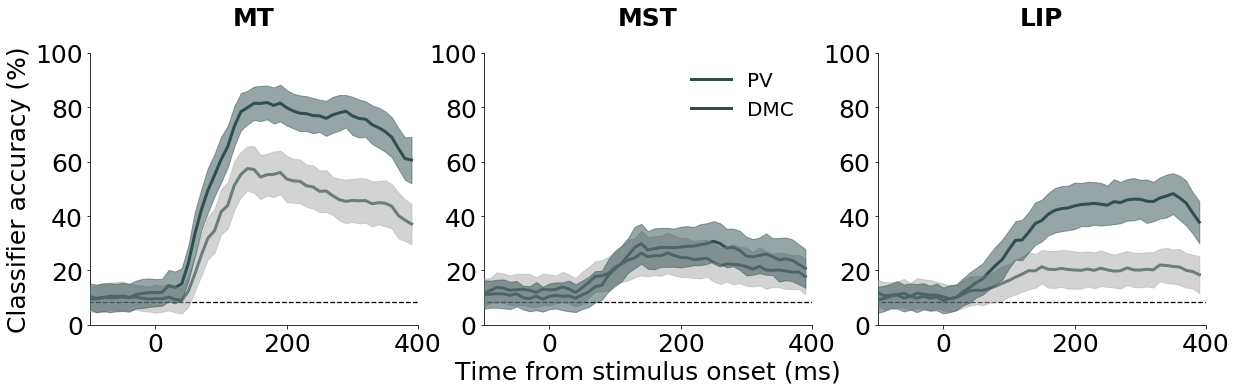

In [466]:
ylim = [0, 100]
chance_level = 1/12*100

if exclude_stim1:  
    savepath = figpath + monkey + '_direction_decoder_sliding_window_trial1_excl.'
else:
    savepath = figpath + monkey + '_direction_decoder_sliding_window.'    

plot_pv_decoder(dir_svm_perf, ylim, chance_level, savepath, brain_areas, save = True)

## Mean across epoch

In [467]:
cat_svm_perf_epoch = {}
dir_svm_perf_epoch = {}

timepoints = np.arange(0, 2)

for area in brain_areas:
    
    if monkey != 'both':
        if exclude_stim1:  
            currpath = datapathsave + monkey + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
        else:
            currpath = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'

        os.chdir(currpath)
        filelist = [f for f in glob.glob("*.mat")]  
    
    else:
        if exclude_stim1:  
            currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
            currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
        else:
            currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_included\\' + window_name + '\\'
            currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_included\\' + window_name + '\\'

        os.chdir(currpath1)
        filelist1 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        os.chdir(currpath2)
        filelist2 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        
        filelist = np.hstack([filelist1, filelist2])
   
    # Run category decoder
    indx1 = np.where(window >= epoch_windows_cat[area][0])[0][0]
    indx2 = np.where(window >= epoch_windows_cat[area][1])[0][0]  
    cat_svm_perf_epoch[area] = run_decoder_pv_epoch(filelist, 'cat', n_trials_cat, n_iter_ep, timepoints, indx1, indx2)

    # Run direction decoder
    indx1 = np.where(window >= epoch_windows_dir[area][0])[0][0]
    indx2 = np.where(window >= epoch_windows_dir[area][1])[0][0]  
    dir_svm_perf_epoch[area] = run_decoder_pv_epoch(filelist, 'dir', n_trials_dir, n_iter_ep, timepoints, indx1, indx2)    
  

In [468]:
cat_svm_perf_epoch['pvals'] = shuffle_decoder_epoch_pv(cat_svm_perf_epoch, n_perms, brain_areas)
dir_svm_perf_epoch['pvals'] = shuffle_decoder_epoch_pv(dir_svm_perf_epoch, n_perms, brain_areas)

sp.io.savemat(datapathsave + monkey + '_cat_decoder_epoch.mat', {'cat_decoder_mean_all': cat_svm_perf_epoch}) 
sp.io.savemat(datapathsave + monkey + '_dir_decoder_epoch.mat', {'dir_decoder_mean_all': dir_svm_perf_epoch})   

### Plot category decoder

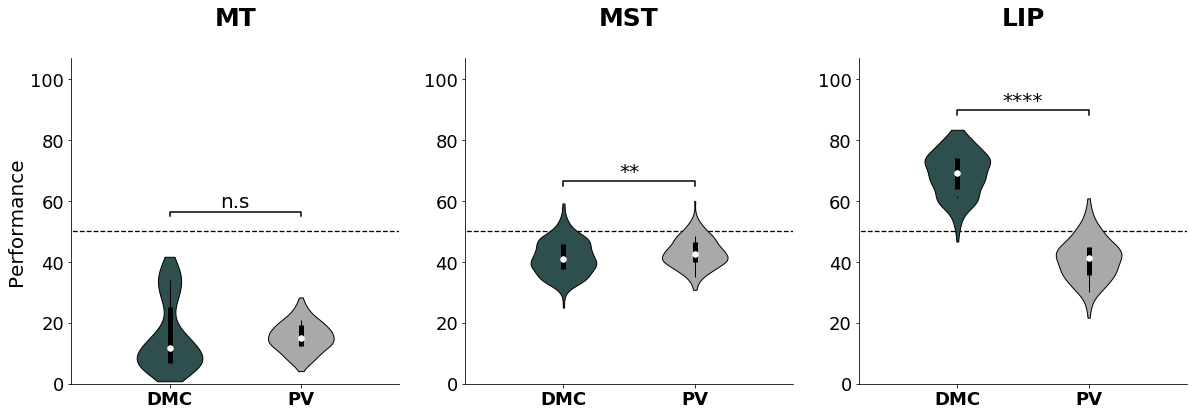

In [469]:
ylim = [0, 107]
chance_level = 50
if exclude_stim1:  
    savepath = figpath + monkey + '_category_decoder_violin_plot_trial1_excl.'
else:
    savepath = figpath + monkey + '_category_decoder_violin_plot.'
plot_pv_dmc_violin(cat_svm_perf_epoch, ylim, chance_level, savepath, brain_areas, tasks, save = True)

### Plot direction decoder

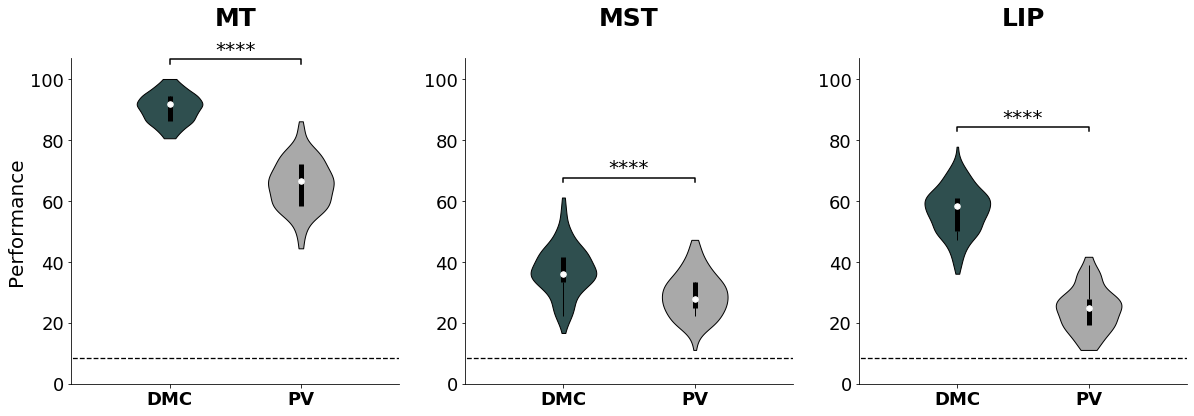

In [470]:
ylim = [0, 107]
chance_level = 1/12*100
if exclude_stim1:  
    savepath = figpath + monkey + '_direction_decoder_violin_plot_trial1_excl.'
else:
    savepath = figpath + monkey + '_direction_decoder_violin_plot.' 
    
plot_pv_dmc_violin(dir_svm_perf_epoch, ylim, chance_level, savepath, brain_areas, tasks, save = True)

# PCA

In [1075]:
monkey = 'Stanton'
n_dims = 12
n_rand = 10000
window_starts = np.arange(-100, 400, 50)
window_ends = window_starts+50

xlabs = ['{}:{}'.format(window_starts[i], window_ends[i]) for i in range(len(window_starts))]

In [1083]:
window = windows[0]
window_name = 'window_' + str(window[0]) + '_' + str(window[-1])

alignment_indices = {'LIP': {'inds': [], 'pvals': [], 'above_rand': []} , 'MST': {'inds': [], 'pvals': [], 'above_rand': []} , 'SC': {'inds': [], 'pvals': [], 'above_rand': []} } 

for window_starts in np.arange(-100, 400, 50):

    timepoints = np.arange(np.where(window == window_starts)[0][0], np.where(window == window_starts+50)[0][0])
    all_variances = {}

    for area in brain_areas[1:]:

        all_variances[area] = {}

        if monkey != 'both':
            if exclude_stim1:  
                currpath = datapathsave + monkey + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
            else:
                currpath = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'

            os.chdir(currpath)
            filelist = [f for f in glob.glob("*.mat")]  
        else:
            if exclude_stim1:  
                currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
                currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
            else:
                currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_included\\' + window_name + '\\'
                currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_included\\' + window_name + '\\'

            os.chdir(currpath1)
            filelist1 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
            os.chdir(currpath2)
            filelist2 = [os.path.abspath(f) for f in glob.glob("*.mat")]  

            filelist = np.hstack([filelist1, filelist2])

        spikes_all = {}
        spikes_all['PV'], spikes_all['DMC'] = [], []

        for file in filelist:
            data = sio.loadmat(file)

            spikes_pv = data['spikes_binned_pv'].flatten()*10
            spikes_dmc = data['spikes_binned_dmc'].flatten()*10
            
            
            #stacked_pv = np.hstack([gaussian_filter1d(np.mean(i[:, timepoints], 0), 30) for i in spikes_pv])
            stacked_pv = np.hstack([gaussian_filter1d(np.mean(i[:, timepoints], 0), 30) for i in spikes_pv])
            stacked_dmc = np.hstack([gaussian_filter1d(np.mean(i[:, timepoints], 0), 30) for i in spikes_dmc])
            #stacked_dmc = np.hstack([gaussian_filter1d(np.mean(i[:, timepoints+50], 0), 30) for i in spikes_pv])
            
            spikes_all['PV'].append(stacked_pv.T)
            spikes_all['DMC'].append(stacked_dmc.T)


        all_stacked = np.array(np.hstack([spikes_all['PV'], spikes_all['DMC']])).T    

        pca = PCA(n_components = len(filelist))
        pca.fit(all_stacked)

        projection = pca.transform(all_stacked)

        n_timepoints = len(timepoints)

        pca_indices = {}

        for i_dir in range(N_DIRS):
            startindx = 0+(n_timepoints*i_dir)
            pca_indices[i_dir] = [startindx, startindx+n_timepoints]

        new_data = projection[:, 0:n_dims]
        dmc = (new_data[0:len(timepoints)*12])
        pv = (new_data[len(timepoints)*12:])

        dmc = np.vstack(dmc)
        pv = np.vstack(pv)

        sp.io.savemat('E:\\two_boundary\\' + area + '.mat', {'dmc': dmc, 'pv': pv})    

        pca = PCA(n_components = n_dims)
        pca.fit(dmc)
        projection = pca.transform(pv)

        vars_proj = [np.var(projection[:, i]) for i in range(n_dims)]
        all_variances[area]['dmc_pv'] = vars_proj

        pca.fit(pv)
        all_variances[area]['pv_pv'] = pca.explained_variance_

        n_rand = n_rand

        random_vals = np.zeros([n_rand, n_dims])
        C = np.cov(pv.T)

        for i_rand in range(n_rand):
            coeffRand = sp.linalg.orth(np.random.rand(n_dims, n_dims))
            random_vals[i_rand] = np.diag(coeffRand.T @ C @ coeffRand)

        all_variances[area]['random'] = random_vals

        data_line =  np.cumsum(all_variances[area]['dmc_pv'])/np.cumsum(all_variances[area]['pv_pv'])
        rand_line = np.cumsum(np.mean(all_variances[area]['random'], 0))/np.cumsum(all_variances[area]['pv_pv'])
        randCum = np.vstack([np.cumsum(row) for row in all_variances[area]['random']])
        randCI = np.quantile(randCum, [0.025, 0.975], 0)/np.cumsum(all_variances[area]['pv_pv'])
        misalign = np.cumsum(list(reversed(all_variances[area]['pv_pv'])))/np.cumsum(all_variances[area]['pv_pv'])

        raw_val = sum(data_line-rand_line)
        if raw_val > 0:
            align_indx = raw_val/sum(1-rand_line)
        else:
            align_indx = raw_val/sum(rand_line - misalign)
             
        alignment_indices[area]['inds'].append(align_indx)
        
        align_vals = np.zeros(n_rand)
        for i in range(n_rand):
            rand = np.cumsum(random_vals[i])/np.cumsum(all_variances[area]['pv_pv'])
            raw_val = sum(rand-rand_line)

            if raw_val > 0:
                align_vals[i] = raw_val/sum(1-rand_line)
            else:
                align_vals[i] = raw_val/sum(rand_line - misalign)
                
        if align_indx > 0:
            alignment_indices[area]['pvals'].append(sum(align_vals > align_indx)/n_rand)
            alignment_indices[area]['above_rand'].append(1)
        else:
            alignment_indices[area]['pvals'].append(-1*sum(align_vals < align_indx)/n_rand)            
            alignment_indices[area]['above_rand'].append(0)
 

In [1071]:
brain_areas[:3]

['MT', 'MST', 'LIP']

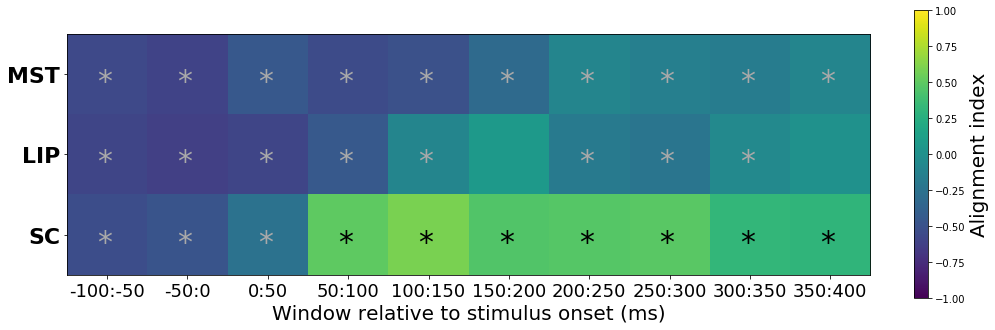

In [1084]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_axes([1,1,1,1])

plt.imshow([alignment_indices[area]['inds'] for area in brain_areas[1:]], vmin=-1, vmax=1)
cbar = plt.colorbar(fraction=0.02)
cbar.set_label('Alignment index', size=20)

ax.set_yticks(np.arange(0, 3, 1))
ax.set_xticks(np.arange(0, len(xlabs), 1))
ax.set(xticklabels = xlabs)
ax.set(yticklabels = brain_areas[1:])

for i_area, area in enumerate(brain_areas[1:]):
    sig_x = np.where(np.array(alignment_indices[area]['pvals']) < 0.05)[0]
    
    for ii in sig_x:
        c = 'darkgrey'
        if alignment_indices[area]['above_rand'][ii] == 1:
            c = 'k'
        ax.text(ii-0.125, i_area+0.2, '*', color = c, fontsize=30)

plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=22, rotation=0, fontweight='bold')

ax.set_xlabel('Window relative to stimulus onset (ms)', fontsize = 20)

for i in save_filetype:
    savepath = 'E:\\two_boundary\\figures\\pca\\' + monkey + '_variance_alignment_dmc_pv_all_timepoints.' + i
    #fig.savefig(savepath, bbox_inches='tight')

In [1074]:
monkey

'Neville'

TypeError: float() argument must be a string or a number, not 'dict'

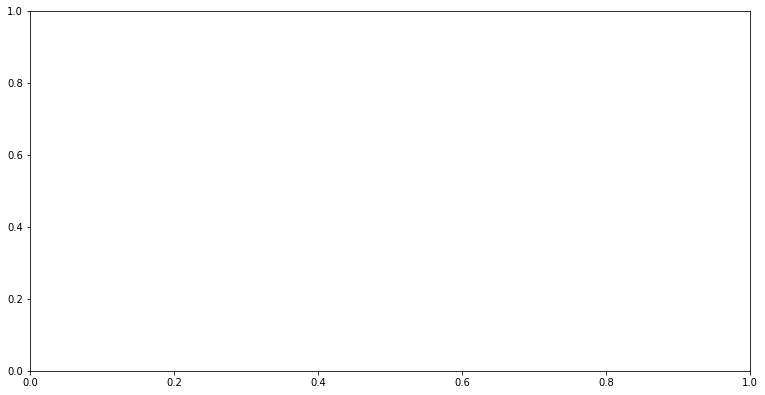

In [2163]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([1,1,1,1])
    
for area in brain_areas:
    ax.plot(alignment_indices[area], color = plot_colors[area], label = area, lw = 2.5)
    
plt.ylim(-1, 1)  
ax.set_xlabel('Window relative to stimulus onset (ms)', fontsize = 20)
ax.set_ylabel('Alignment index', fontsize = 16)
ax.legend(frameon = False, fontsize = 16)
ax.set(xticklabels = xlabs)

#plt.xticks(fontsize=20, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

for i in save_filetype:
    savepath = 'E:\\two_boundary\\figures\\pca\\' + monkey + '_variance_alignment_dmc_pv.' + i
    #fig.savefig(savepath, bbox_inches='tight')

In [1081]:
plot_colors['SC'] = 'teal'

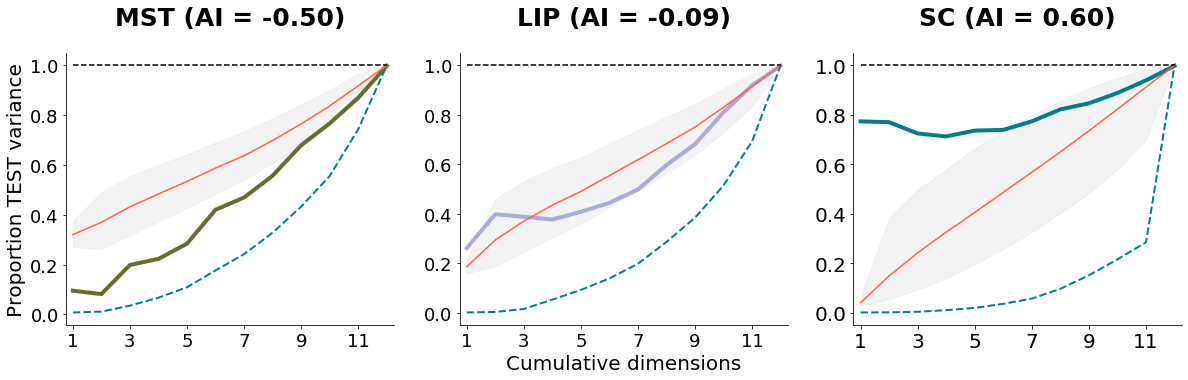

In [1082]:
fig, ax =  plt.subplots(1, 3, figsize=(20, 5))
    
for i, area in enumerate(brain_areas[1:]):
    
    data_line =  np.cumsum(all_variances[area]['dmc_pv'])/np.cumsum(all_variances[area]['pv_pv'])
    rand_line = np.cumsum(np.mean(all_variances[area]['random'], 0))/np.cumsum(all_variances[area]['pv_pv'])
    randCum = np.vstack([np.cumsum(row) for row in all_variances[area]['random']])
    randCI = np.quantile(randCum, [0.025, 0.975], 0)/np.cumsum(all_variances[area]['pv_pv'])
    misalign = np.cumsum(list(reversed(all_variances[area]['pv_pv'])))/np.cumsum(all_variances[area]['pv_pv'])
    
    raw_val = sum(data_line-rand_line)
    if raw_val > 0:
        align_indx = raw_val/sum(1-rand_line)
    else:
        align_indx = raw_val/sum(rand_line - misalign)

    
    #tmp = all_variances[area]['dmc_pv']/all_variances[area]['pv_pv']
    ax[i].plot(range(1, n_dims+1),data_line, color = plot_colors[area], lw = 4)
    ax[i].plot(range(1, n_dims+1), misalign, '--', color = 'teal', label = 'Maximally misaligned', lw = 2)
    ax[i].plot(range(1, n_dims+1), rand_line, color = 'tomato', label = 'Random')
    ax[i].plot(range(1, n_dims+1), np.ones(n_dims), '--', color = 'k', label = 'Perfect alignment')
    ax[i].fill_between(range(1, n_dims+1), randCI[0], randCI[1], color = 'lightgrey', lw = 1., alpha = 0.25)
    #ax[i].plot(range(1, n_dims+1), np.cumsum(all_variances[area]['dmc_pv']), color = plot_colors[area], label = area, lw = 2)

    ax[i].set_xlim(0.75, n_dims + 0.25)
    ax[i].set_xticks(np.arange(1, n_dims+1, 2))
    #ax[i].legend(frameon = False, fontsize = 20)
    #plt.ylim(0, 1.1)
    ax[i].set_title(area + ' (AI = {:.2f})'.format(align_indx), fontsize = 25, y = 1.08, fontweight='bold')

    ax[i].tick_params(labelsize = 18)

    # Hide the right and top spines
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    plt.tick_params(labelsize=20)
    
ax[1].set_xlabel('Cumulative dimensions', fontsize = 20)
ax[0].set_ylabel('Proportion TEST variance', fontsize = 20)

for i in save_filetype:
    savepath = 'E:\\two_boundary\\figures\\pca\\' + monkey + '_variance_alignment_dmc_pv_0_50.' + i
    #fig.savefig(savepath, bbox_inches='tight')

(0, 1.01)

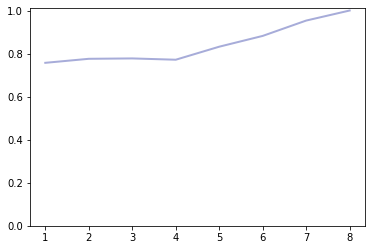

In [862]:
%matplotlib inline

plt.plot(range(1, n_dims+1), np.cumsum(vars_proj/sum(vars_proj))/np.cumsum(pca.explained_variance_ratio_), color = plot_colors[area], label = area, lw = 2)
plt.ylim(0, 1.01)

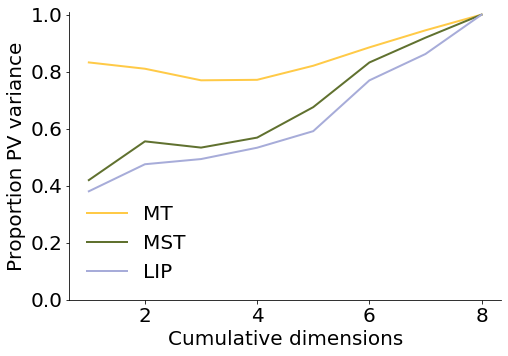

In [900]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([1,1,1,1])
    
for area in brain_areas:
    #tmp = all_variances[area]['samp_test']/all_variances[area]['test_test']
    ax.plot(range(1, n_dims+1), np.cumsum(all_variances[area]['dmc_pv'])/np.cumsum(all_variances[area]['pv_pv']), color = plot_colors[area], label = area, lw = 2)
    #ax.plot(range(1, 11), np.cumsum(all_variances[area]['samp_test']), color = plot_colors[area], label = area, lw = 2)
    
ax.set_xlabel('Cumulative dimensions', fontsize = 20)
ax.set_ylabel('Proportion PV variance', fontsize = 20)
ax.legend(frameon = False, fontsize = 20)
plt.ylim(0, 1.01)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

for i in save_filetype:
    savepath = 'E:\\two_boundary\\figures\\pca\\' + monkey + '_variance_alignment_dmc_pv.' + i
    fig.savefig(savepath, bbox_inches='tight')


In [18]:
window = windows[0]
window_name = 'window_' + str(window[0]) + '_' + str(window[-1])
timepoints = np.arange(0, len(window))

for area in brain_areas[0:1]:
    
    if monkey != 'both':
        if exclude_stim1:  
            currpath = datapathsave + monkey + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
        else:
            currpath = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'

        os.chdir(currpath)
        filelist = [f for f in glob.glob("*.mat")]  
    else:
        if exclude_stim1:  
            currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
            currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
        else:
            currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_included\\' + window_name + '\\'
            currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_included\\' + window_name + '\\'

        os.chdir(currpath1)
        filelist1 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        os.chdir(currpath2)
        filelist2 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        
        filelist = np.hstack([filelist1, filelist2])
        
    spikes_all = {}
    spikes_all['PV'], spikes_all['DMC'] = [], []

    for file in filelist:
        data = sio.loadmat(file)
        
        spikes_pv = data['spikes_binned_pv'].flatten()*10
        spikes_dmc = data['spikes_binned_dmc'].flatten()*10
        
        stacked_pv = np.hstack([gaussian_filter1d(np.mean(i, 0), 30) for i in spikes_pv])
        stacked_dmc = np.hstack([gaussian_filter1d(np.mean(i, 0), 30) for i in spikes_dmc])
        
        spikes_all['PV'].append(stacked_pv.T)
        spikes_all['DMC'].append(stacked_dmc.T)
        
    #for task in tasks:
        #cat_perf_all[task] = category_decoder(spikes_all[task], n_iter_sw, timepoints, n_neurons_decoder, n_neurons_decoder, n_trials_cat)    
        #dir_perf_all[task] = direction_decoder(spikes_all[task], n_iter_sw, timepoints, n_neurons_decoder, n_neurons_decoder, n_trials_dir)    
    


In [897]:
TEST1

2300

In [686]:
tmp = [gaussian_filter1d(np.mean(i, 0), 30) for i in spikes_pv]

for i in range(6):
    plt.plot(tmp[i],'r')
    
for i in range(6, 12):
    plt.plot(tmp[i],'b')


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [19]:
from sklearn.decomposition import PCA

all_stacked = np.array(spikes_all['PV']).T    

pca = PCA(n_components = len(filelist))
pca.fit(all_stacked)

projection = pca.transform(all_stacked)


In [20]:
np.shape(all_stacked)

(6000, 208)

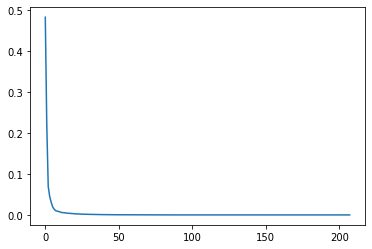

In [21]:
plt.plot(pca.explained_variance_ratio_)

In [22]:
%matplotlib inline

for i_dir in range(6):
    plt.plot(projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 0], projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 1], 'r')
    
for i_dir in range(6, 12):
    plt.plot(projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 0], projection[pca_indices[i_dir][0]:pca_indices[i_dir][1], 1], 'b')



NameError: name 'pca_indices' is not defined

In [810]:
n_timepoints = len(timepoints)-1

pca_indices = {}

for i_dir in range(N_DIRS):
    startindx = timepoints[0]+(n_timepoints*i_dir)
    pca_indices[i_dir] = [startindx, startindx+n_timepoints]

<IPython.core.display.Javascript object>


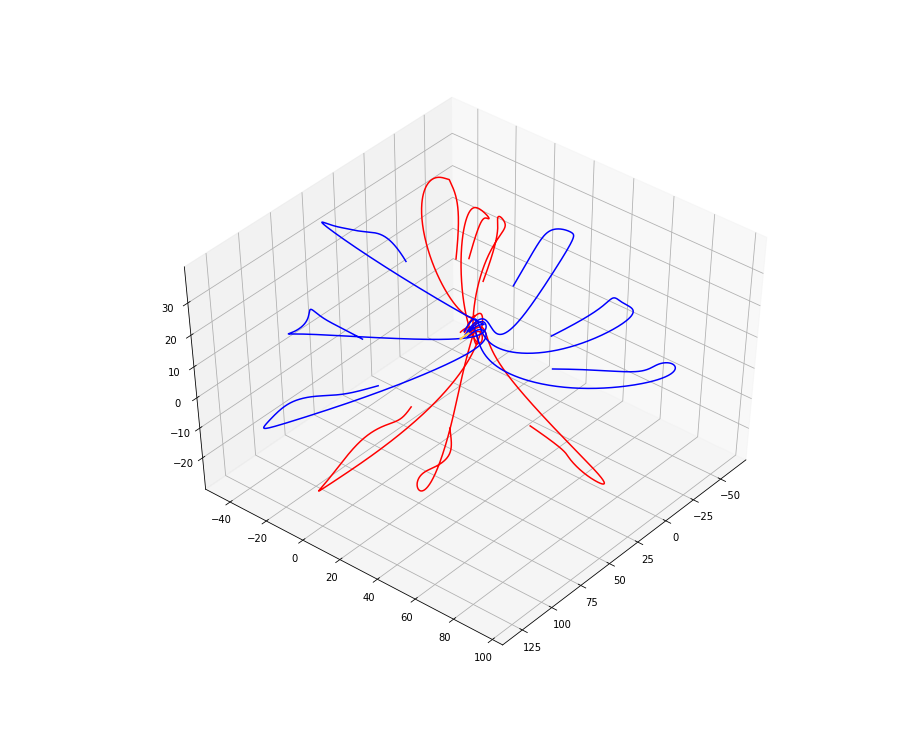

In [812]:
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

for i_dir in range(6):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], 'r')
    
for i_dir in range(6, 12):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], 'b')



<IPython.core.display.Javascript object>


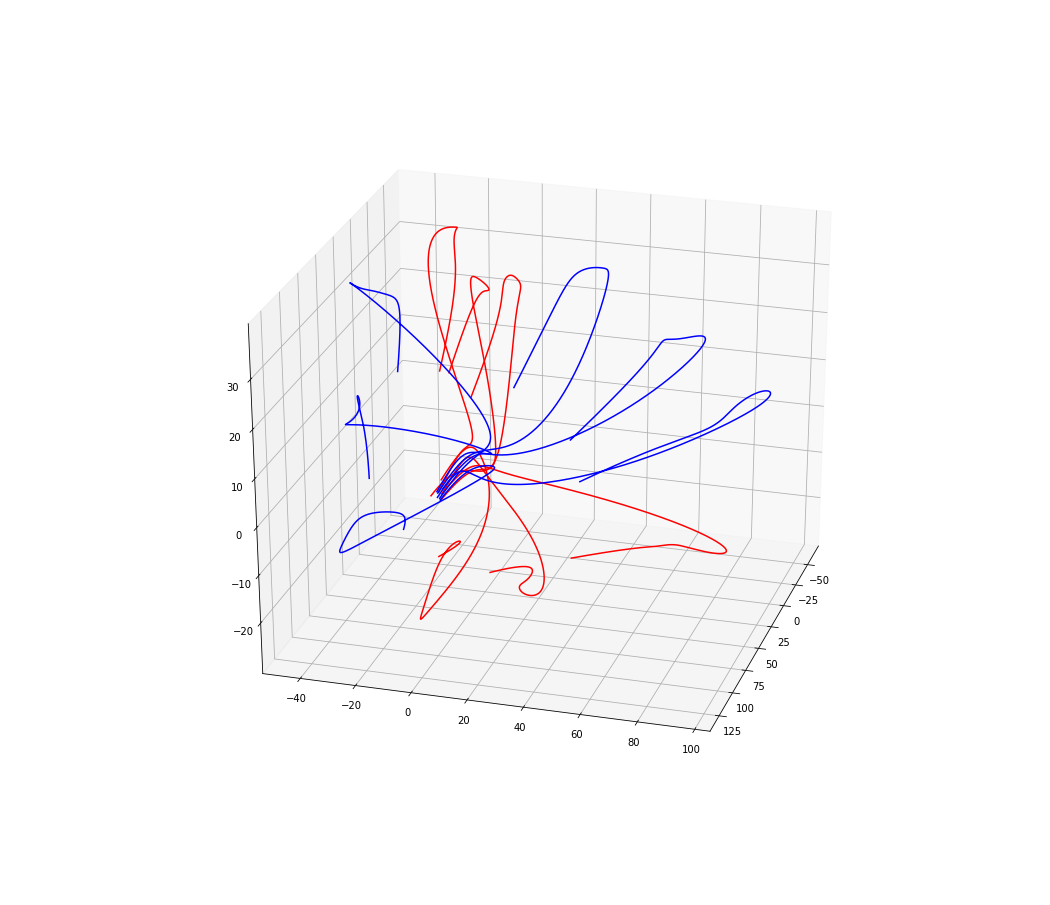

In [700]:
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

for i_dir in range(6):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], 'r')
    
for i_dir in range(6, 12):
    inds = pca_indices[i_dir]
    ax.plot(projection[inds[0]:inds[1], 0], projection[inds[0]:inds[1], 1], projection[inds[0]:inds[1], 2], 'b')



In [12]:
center_dirs = [i for i, val in enumerate(DIRS) if isinstance(val, int)]
vert_dirs = [3, 8, 0, 11]
horz_dirs = [5, 6, 2, 9]

In [18]:
monkey = 'Stanton'
area = 'SC'

indx1 = np.where(window >= 100)[0][0] #50
indx2 = np.where(window >= 250)[0][0] #200

timepoints = np.arange(50, 250, 50)

In [19]:
if monkey != 'both':
    currpath = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'
    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]    
else:
    currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_included\\' + window_name + '\\'
    currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_included\\' + window_name + '\\'

    os.chdir(currpath1)
    filelist1 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
    os.chdir(currpath2)
    filelist2 = [os.path.abspath(f) for f in glob.glob("*.mat")]  

    filelist = np.hstack([filelist1, filelist2])

n_files = len(filelist)

pref_dir = {'DMC': np.zeros(len(filelist)), 'PV': np.zeros(len(filelist))}

for i_file, file in enumerate(filelist):
    data = sio.loadmat(file)['spikes_binned_pv'][0]*10
    data_epoch = [np.mean(data[i][:, indx1:indx2], 1) for i in range(N_DIRS)]
    
    tmp = list(sp.stats.zscore(np.hstack(data_epoch)))
    data_epoch_z = np.zeros_like(data_epoch)
    for i_dir in range(N_DIRS):
        data_epoch_z[i_dir] = tmp[0:len(data_epoch[i_dir])]
        del tmp[0:len(data_epoch[i_dir])]
        
    means = [np.mean(i) for i in data_epoch_z]
    
    [f, pval] = stats.f_oneway(data_epoch_z[0], data_epoch_z[1], data_epoch_z[2], data_epoch_z[3], data_epoch_z[4], data_epoch_z[5], data_epoch_z[6], data_epoch_z[7], data_epoch_z[8], data_epoch_z[9], data_epoch_z[10], data_epoch_z[11])
    
    if pval < 0.05:
        indx = np.argmax(means)   
        pref_dir['PV'][i_file] = indx
    else:
        pref_dir['PV'][i_file] = np.nan
    
    data = sio.loadmat(file)['spikes_binned_dmc'][0]*10
    data_epoch = [np.mean(data[i][:, indx1:indx2], 1) for i in range(N_DIRS)]
    tmp = list(sp.stats.zscore(np.hstack(data_epoch)))
    data_epoch_z = np.zeros_like(data_epoch)
    for i_dir in range(N_DIRS):
        data_epoch_z[i_dir] = tmp[0:len(data_epoch[i_dir])]
        del tmp[0:len(data_epoch[i_dir])]
        
    means = [np.mean(i) for i in data_epoch_z]
    
    [f, pval] = stats.f_oneway(data_epoch_z[0], data_epoch_z[1], data_epoch_z[2], data_epoch_z[3], data_epoch_z[4], data_epoch_z[5], data_epoch_z[6], data_epoch_z[7], data_epoch_z[8], data_epoch_z[9], data_epoch_z[10], data_epoch_z[11])
        
    if pval < 0.05:
        indx = np.argmax(means)   
        pref_dir['DMC'][i_file] = indx
    else:
        pref_dir['DMC'][i_file] = np.nan    

ord_ind = np.argsort(DIRS)
ord_dirs = [DIRS[i] for i in ord_ind]
objects = [str(i) for i in ord_dirs]
y_pos = np.arange(len(objects))


In [20]:
if monkey != 'both':
    currpath = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'
    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]    
else:
    currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_included\\' + window_name + '\\'
    currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_included\\' + window_name + '\\'

    os.chdir(currpath1)
    filelist1 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
    os.chdir(currpath2)
    filelist2 = [os.path.abspath(f) for f in glob.glob("*.mat")]  

    filelist = np.hstack([filelist1, filelist2])

pref_dir = {'DMC': np.zeros(len(filelist)), 'PV': np.zeros(len(filelist))}

for i_file, file in enumerate(filelist):
    
    data = sio.loadmat(file)['spikes_binned_dmc'][0]*10

    anova_results = np.zeros([len(timepoints), 2])

    for ii, indx in enumerate(timepoints):

        curr_indx = np.where(window >= indx)[0][0]

        data_epoch = [np.mean(data[i][:, curr_indx:curr_indx+50], 1) for i in range(N_DIRS)]
        tmp = list(sp.stats.zscore(np.hstack(data_epoch)))
        data_epoch_z = np.zeros_like(data_epoch)
        for i_dir in range(N_DIRS):
            data_epoch_z[i_dir] = tmp[0:len(data_epoch[i_dir])]
            del tmp[0:len(data_epoch[i_dir])]

        means = [np.mean(i) for i in data_epoch_z]

        [f, pval] = stats.f_oneway(data_epoch_z[0], data_epoch_z[1], data_epoch_z[2], data_epoch_z[3], data_epoch_z[4], data_epoch_z[5], data_epoch_z[6], data_epoch_z[7], data_epoch_z[8], data_epoch_z[9], data_epoch_z[10], data_epoch_z[11])

        anova_results[ii] = [f, pval]

    time_max_diff = timepoints[np.argmax([i[0] for i in anova_results])]
    
    #print(time_max_diff)
    
    curr_indx = np.where(window >= time_max_diff)[0][0]
    data_epoch = [np.mean(data[i][:, curr_indx:curr_indx+50], 1) for i in range(N_DIRS)]
    tmp = list(sp.stats.zscore(np.hstack(data_epoch)))
    data_epoch_z = np.zeros_like(data_epoch)
    for i_dir in range(N_DIRS):
        data_epoch_z[i_dir] = tmp[0:len(data_epoch[i_dir])]
        del tmp[0:len(data_epoch[i_dir])]

    means = [np.mean(i) for i in data_epoch_z]

    [f, pval] = stats.f_oneway(data_epoch_z[0], data_epoch_z[1], data_epoch_z[2], data_epoch_z[3], data_epoch_z[4], data_epoch_z[5], data_epoch_z[6], data_epoch_z[7], data_epoch_z[8], data_epoch_z[9], data_epoch_z[10], data_epoch_z[11])
    if pval < 0.05:
        indx = np.argmax(means)   
        pref_dir['DMC'][i_file] = indx
    else:
        pref_dir['DMC'][i_file] = np.nan    
    
    
    data = sio.loadmat(file)['spikes_binned_pv'][0]*10
    data_epoch = [np.mean(data[i][:, curr_indx:curr_indx+50], 1) for i in range(N_DIRS)]
    
    tmp = list(sp.stats.zscore(np.hstack(data_epoch)))
    data_epoch_z = np.zeros_like(data_epoch)
    for i_dir in range(N_DIRS):
        data_epoch_z[i_dir] = tmp[0:len(data_epoch[i_dir])]
        del tmp[0:len(data_epoch[i_dir])]
        
    means = [np.mean(i) for i in data_epoch_z]
    
    [f, pval] = stats.f_oneway(data_epoch_z[0], data_epoch_z[1], data_epoch_z[2], data_epoch_z[3], data_epoch_z[4], data_epoch_z[5], data_epoch_z[6], data_epoch_z[7], data_epoch_z[8], data_epoch_z[9], data_epoch_z[10], data_epoch_z[11])
    
    if pval < 0.05:
        indx = np.argmax(means)   
        pref_dir['PV'][i_file] = indx
    else:
        pref_dir['PV'][i_file] = np.nan
    
ord_ind = np.argsort(DIRS)
ord_dirs = [DIRS[i] for i in ord_ind]
objects = [str(i) for i in ord_dirs]
y_pos = np.arange(len(objects))

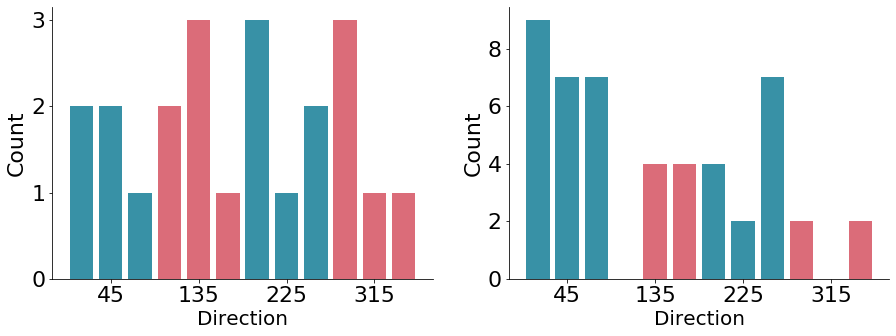

In [21]:
savepath = figpath + monkey + '_' + area + '_dir_pref_hist.'

colors = [plot_colors['Category1'], plot_colors['Category1'], plot_colors['Category1'], plot_colors['Category2'], plot_colors['Category2'], plot_colors['Category2'], plot_colors['Category1'], plot_colors['Category1'], plot_colors['Category1'], plot_colors['Category2'], plot_colors['Category2'], plot_colors['Category2']]
xtick_dirs = [ord_dirs[i] for i in np.arange(1, 11, 3)]
fig, ax =  plt.subplots(1, 2, figsize=(15, 5))

for i, task in enumerate(tasks):
    hist_dirs = np.histogram(pref_dir[task], np.arange(0, 13, 1))[0]
    hist_dirs = [hist_dirs[i] for i in ord_ind]
    
    ax[i].bar(y_pos+1, hist_dirs, align='center', color = colors)
    ax[i].set_xticks(np.arange(2, 12, 3))
    ax[i].set(xticklabels = xtick_dirs)
    
    #ax[i].set_ylim(0, 10)
    #ax[i].set(yticklabels = np.arange(0, 100, 3))
    ax[i].tick_params(labelsize=22)
    ax[i].set_ylabel('Count', fontsize = 22)
    ax[i].set_xlabel('Direction', fontsize = 20)
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    
for i in save_filetype:
    savename = savepath + i
    #fig.savefig(savename, bbox_inches='tight')

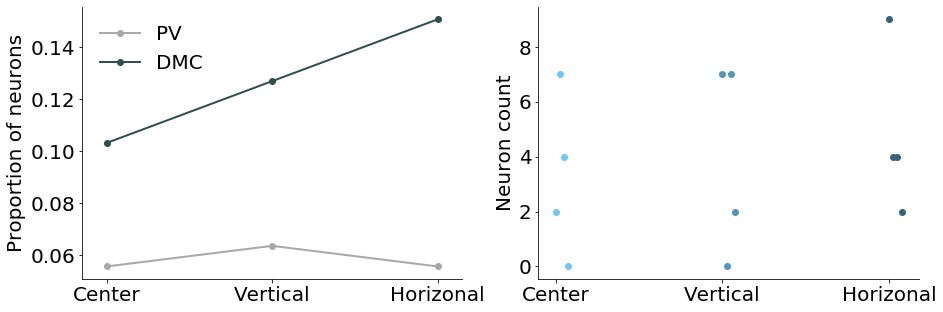

In [22]:
savepath = figpath + monkey + '_' + area + '_dir_pref_diff.'

fig, ax =  plt.subplots(1, 2, figsize=(15, 5))

pv_nums = np.array([sum(sum(pref_dir['PV'] == center_dirs[i])/n_files for i in range(4)), 
           sum(sum(pref_dir['PV'] == vert_dirs[i])/n_files for i in range(4)), 
           sum(sum(pref_dir['PV'] == horz_dirs[i])/n_files for i in range(4))])

dmc_nums = np.array([sum(sum(pref_dir['DMC'] == center_dirs[i])/n_files for i in range(4)), 
           sum(sum(pref_dir['DMC'] == vert_dirs[i])/n_files for i in range(4)), 
           sum(sum(pref_dir['DMC'] == horz_dirs[i])/n_files for i in range(4))])

ax[0].plot(pv_nums, color = plot_colors['PV'], lw = 2, marker = 'o', label = 'PV')
ax[0].plot(dmc_nums, color = plot_colors['DMC'], lw = 2, marker = 'o', label = 'DMC')

#ax[0].plot(dmc_nums-pv_nums, color = 'tomato', lw = 2, marker = 'o')

ax[0].set_ylabel('Proportion of neurons', fontsize = 20)
ax[0].set_xticks(np.arange(0, 3, 1))
ax[0].set(xticklabels = ['Center', 'Vertical', 'Horizonal'])
ax[0].legend(frameon = False, fontsize = 20)

ax[0].set_xlim(-0.15, 2.15)
#ax[0].set_ylim(0.05, 0.21)

# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].tick_params(labelsize=20)


center = np.vstack([[0+ii/40, sum(pref_dir['DMC'] == i)] for ii, i in enumerate(center_dirs)])
vert = np.vstack([[1+ii/40, sum(pref_dir['DMC'] == i)] for ii, i in enumerate(vert_dirs)])
horz = np.vstack([[2+ii/40, sum(pref_dir['DMC'] == i)] for ii, i in enumerate(horz_dirs)])

ax[1].plot(np.vstack(center.T)[0], np.vstack(center.T)[1], 'o', color = '#71C6F9')
ax[1].plot(np.vstack(vert.T)[0], np.vstack(vert.T)[1], 'o', color = '#5595BB')
ax[1].plot(np.vstack(horz.T)[0], np.vstack(horz.T)[1], 'o', color = '#38637C')

ax[1].set_xticks(np.arange(0, 3, 1))
ax[1].set(xticklabels = ['Center', 'Vertical', 'Horizonal'])
ax[1].set_ylabel('Neuron count', fontsize = 20)

# Hide the right and top spines
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].tick_params(labelsize=20)
#ax[1].set_ylim(0, 14)
#ax[1].set_yticks(np.arange(2, 17, 4))

plt.show()
for i in save_filetype:
    savename = savepath + i
    #fig.savefig(savename, bbox_inches='tight')

# Correlation analysis

In [144]:
# Get number of neurons per area
n_neurons = {}
for area in brain_areas:
    datadir = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'
    os.chdir(datadir)
    n_neurons[area] = len([f for f in glob.glob("*.mat")])

In [145]:
# For all windows except -100:400 and -500:0
corr_all_areas = {}

indx1 = np.where(window >= 100)[0][0]
indx2 = np.where(window >= 400)[0][0]  

for area in brain_areas:
    if exclude_stim1:  
        currpath = datapathsave + monkey + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
    else:
        currpath = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'

    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]    

    corr_all = []   
    
    for file in filelist:
        data = sio.loadmat(file)
        neuron_name = file[0:-5]

        window_mean_pv = np.hstack([np.mean(np.mean(data['spikes_binned_pv'].flatten()[i][:, indx1:indx2], 1)) for i in range(N_DIRS)])
        window_mean_dmc = np.hstack([np.mean(np.mean(data['spikes_binned_dmc'].flatten()[i][:, indx1:indx2], 1)) for i in range(N_DIRS)])

        # Compute tuning curve correlation
        curr_corr = np.corrcoef(window_mean_pv, window_mean_dmc)[0][1]
        corr_all.append(curr_corr)

    corr_all_areas[area] = corr_all

In [146]:
### Calculate ECDF
ecdf_x_all = {}
ecdf_y_all = {}

for area in brain_areas:
    [x, y] = ecdf(corr_all_areas[area])

    ecdf_x_all[area] = x
    ecdf_y_all[area] = y

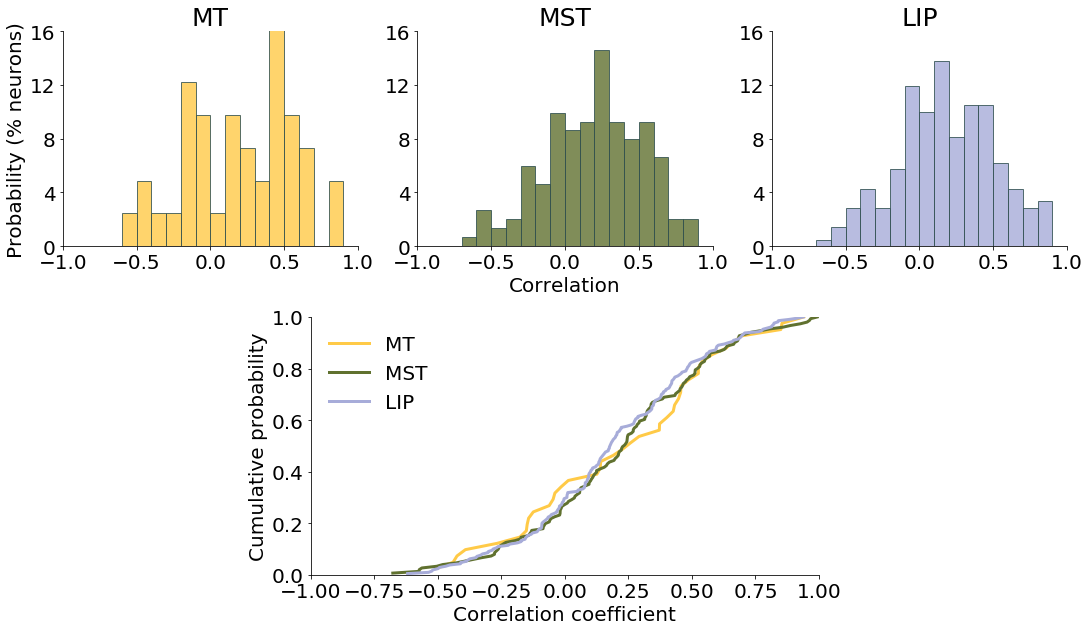

In [147]:

### Plot correlations
fig = plt.figure()
ax = fig.subplots(2, 6)
plt.close()
fig = plt.figure(constrained_layout=False, figsize=(18, 10))
widths = [4, 1, 4, 1, 1, 4]
heights = [1, 1.2]
gs = fig.add_gridspec(ncols = 6, nrows = 2, width_ratios = widths, height_ratios = heights, wspace = 0.5, hspace = 0.3)

ax[0, 0] = fig.add_subplot(gs[0, 0:2])
ax[0, 1]  = fig.add_subplot(gs[0, 2:4])
ax[0, 2]  = fig.add_subplot(gs[0, 4:])
ax[1, 0]  = fig.add_subplot(gs[1:, 1:5])

for i, area in enumerate(brain_areas):
    [hists, edges] = np.histogram(corr_all_areas[area], bins = np.arange(-1, 1, 0.1))
    ax[0, i].bar(edges[:-1], hists/n_neurons[area]*100, 0.1, edgecolor = 'darkslategrey', alpha = 0.8, facecolor = plot_colors[area], label = area, align = 'edge', zorder = 20)  
    #ax[0, i].hist(corr_all_areas[area], bins = np.arange(-1, 1, 0.1), edgecolor = 'darkslategrey', alpha = 0.8, density = False, facecolor = plot_colors[area], label = area)
    ax[0, i].set_title(area, fontsize = 25)
    ax[0, i].set_xlim(-1, 1)
    ax[0, i].tick_params(labelsize=20)
    ax[0, i].set_ylim(0, 16)

    ax[0, i].set_yticks(np.arange(0, 17, 4))

ax[0, 0].set_ylabel('Probability (% neurons)', fontsize = 20)
ax[0, 1].set_xlabel('Correlation', fontsize = 20)

# Hide the right and top spines
for i in range(3):
    ax[0, i].spines['right'].set_visible(False)
    ax[0, i].spines['top'].set_visible(False)

for i, area in enumerate(brain_areas):
    ax[1, 0].plot(ecdf_x_all[area], ecdf_y_all[area], color = plot_colors[area], lw = 3, label = area)

ax[1, 0].set_xlabel('Correlation coefficient', fontsize = 20)
ax[1, 0].set_ylabel('Cumulative probability', fontsize = 20)
plt.xlim(-1, 1)
plt.ylim(0, 1)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

ax[1, 0].legend(frameon = False, fontsize = 20)

plt.show()
for i in save_filetype:
    if exclude_stim1:
        savepath = figpath + monkey + '_pv_corr_stim1_excl_' + '.' + i
    else:
        savepath = figpath + monkey + '_pv_corr_stim1_incl_' + '.' + i  
    fig.savefig(savepath, bbox_inches='tight')
plt.close()

# Rate analysis

In [1023]:
# For all windows except -100:400
rate_pv_areas = {}
rate_dmc_areas = {}


for area in brain_areas:
    if exclude_stim1:  
        currpath = datapathsave + monkey + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
    else:
        currpath = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'

    os.chdir(currpath)
    filelist = [f for f in glob.glob("*.mat")]    

    rate_pv_all = []
    rate_dmc_all = []

    for file in filelist:
        data = sio.loadmat(file)
        neuron_name = file[0:-5]

        window_mean_pv = np.hstack([np.mean(np.mean(data['spikes_binned_pv'].flatten()[i][:, indx1:indx2], 1)) for i in range(N_DIRS)])
        window_mean_dmc = np.hstack([np.mean(np.mean(data['spikes_binned_dmc'].flatten()[i][:, indx1:indx2], 1)) for i in range(N_DIRS)])

        # Compute overall mean firing rates
        curr_rate_pv = np.mean(window_mean_pv)*10
        curr_rate_dmc = np.mean(window_mean_dmc)*10
        rate_pv_all.append(curr_rate_pv)
        rate_dmc_all.append(curr_rate_dmc)

    rate_pv_areas[area] = rate_pv_all
    rate_dmc_areas[area] = rate_dmc_all



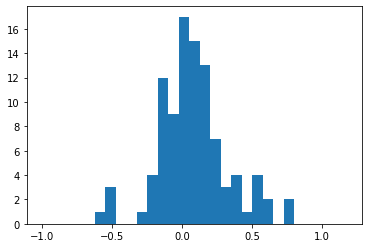

In [1024]:
area = 'SC'
mod_indx = [(rate_dmc_areas[area][i]-rate_pv_areas[area][i])/(rate_dmc_areas[area][i]+rate_pv_areas[area][i]) for i in range(len(rate_dmc_areas[area]))]

plt.hist(mod_indx, np.arange(-1, 1.2, 0.075))
plt.show()

(0, 120)

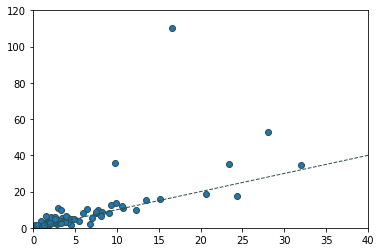

In [1029]:
plt.plot([0, 120], [0, 120], '--', color = 'darkslategrey', lw = 1)
plt.scatter(rate_pv_areas['SC'], rate_dmc_areas['SC'], edgecolor = 'darkslategrey', label = area)
plt.xlim(0, 40)
plt.ylim(0, 120)

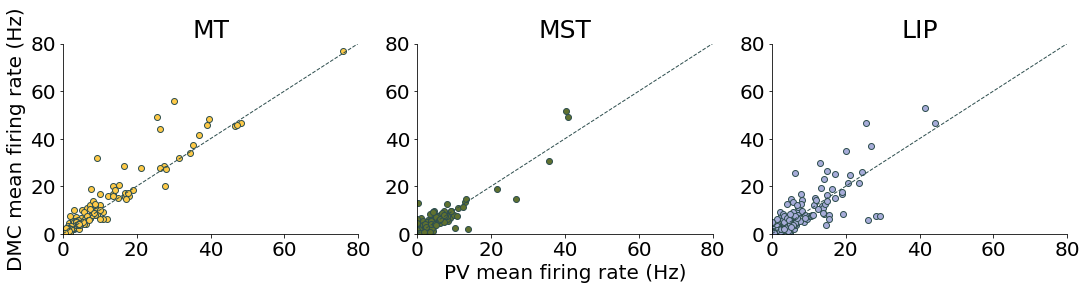

In [172]:
### Plot rates   
fig, ax =  plt.subplots(1, 3, figsize=(18, 3.5))

for i, area in enumerate(brain_areas):
    ax[i].plot([0, 120], [0, 120], '--', color = 'darkslategrey', lw = 1)
    ax[i].scatter(rate_pv_areas[area], rate_dmc_areas[area], edgecolor = 'darkslategrey', facecolor = plot_colors[area], label = area)
    ax[i].set_title(area, fontsize = 25)
    ax[i].set_xlim(0, 80)
    ax[i].set_ylim(0, 80)
    ax[i].tick_params(labelsize=20)

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

ax[0].set_ylabel('DMC mean firing rate (Hz)', fontsize = 20)
ax[1].set_xlabel('PV mean firing rate (Hz)', fontsize = 20)

# Hide the right and top spines
#for i in range(3):
    #ax[i].spines['right'].set_visible(False)
    #ax[i].spines['top'].set_visible(False)

plt.show()
for i in save_filetype:
    if exclude_stim1:
        savepath = figpath + monkey + '_pv_dmc_rate_stim1_excl_' + '.' + i
    else:
        savepath = figpath + monkey + '_pv_dmc_rate_stim1_incl_' + '.' + i
    #fig.savefig(savepath, bbox_inches='tight')

plt.close()

In [33]:


center_inds = [i for i, val in enumerate(dirs) if isinstance(val, int)]
border_inds = [3, 8, 6, 9, 0, 5, 2, 11]


BCD_pairs = [[22.5, 157.5], [112.5, 247.5], [202.5, 337.5], [292.5, 67.5], [67.5, 112.5], [157.5, 202.5], [247.5, 292.5], [337.5, 22.5]]
BCD_pairs_indx = [[np.where(dirs == i[0])[0][0], np.where(dirs == i[1])[0][0]] for i in BCD_pairs]

WCD_pairs = [[337.5, 112.5], [157.5, 292.5], [67.5, 202.5], [247.5, 22.5], [22.5, 67.5], [202.5, 247.5], [112.5, 157.5], [292.5, 337.5]]
WCD_pairs_indx = [[np.where(dirs == i[0])[0][0], np.where(dirs == i[1])[0][0]] for i in WCD_pairs]






## Task decoding

In [5]:
monkey = 'Neville'

In [6]:
n_neurons_total

NameError: name 'n_neurons_total' is not defined

In [7]:
n_iter = 200

task_svm_perf = {}

window = windows[1]
window_name = 'window_' + str(window[0]) + '_' + str(window[-1])
timepoints = np.arange(0, len(window))

for area in brain_areas:
    
    if monkey != 'both':
        if exclude_stim1:  
            currpath = datapathsave + monkey + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
        else:
            currpath = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'

        os.chdir(currpath)
        filelist = [f for f in glob.glob("*.mat")]  
    else:
        if exclude_stim1:  
            currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
            currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
        else:
            currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_included\\' + window_name + '\\'
            currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_included\\' + window_name + '\\'

        os.chdir(currpath1)
        filelist1 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        os.chdir(currpath2)
        filelist2 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        
        filelist = np.hstack([filelist1, filelist2])
        
    n_neurons_decoder = len(filelist)

    spikes_all = {}
    spikes_all['PV'], spikes_all['DMC'] = [], []

    for file in filelist:
        data = sio.loadmat(file)
        
        pv_data = data['spikes_binned_pv'].flatten()
        dmc_data = data['spikes_binned_dmc'].flatten()
        
        spikes_all['PV'].append([np.mean(i, 1) for i in pv_data])
        spikes_all['DMC'].append([np.mean(i, 1) for i in dmc_data])
        #spikes_all['PV'].append(data['spikes_binned_pv'].flatten())
        #spikes_all['DMC'].append(data['spikes_binned_dmc'].flatten())
        
    task_svm_perf[area] = task_decoder(spikes_all['PV'], spikes_all['DMC'], n_iter, [0], n_neurons_decoder, n_neurons_decoder, 10)
    
#sp.io.savemat(datapathsave + monkey + '_cat_decoder_sliding_window.mat', {'cat_decoder_mean_all': cat_svm_perf}) 
#sp.io.savemat(datapathsave + monkey + '_dir_decoder_sliding_window.mat', {'dir_decoder_mean_all': dir_svm_perf})   

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'E:\\two_boundary\\data_pv\\Neville\\MT\\stim1_included\\window_-500_0\\'

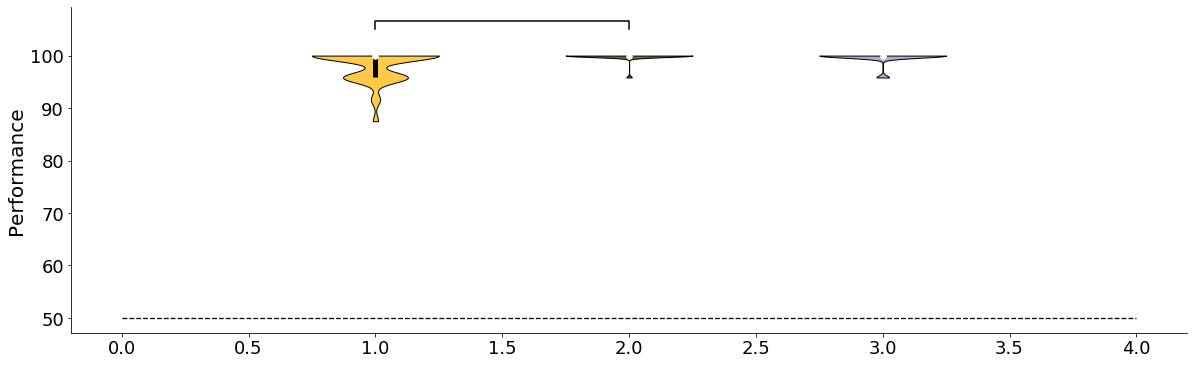

In [434]:
violin_colors = [plot_colors['MT'], plot_colors['MST'], plot_colors['LIP']]

fig, ax =  plt.subplots(1, 1, figsize=(20, 6))
x1, x2, x3 = 1, 2, 3

data = [np.hstack(task_svm_perf['MT']), np.hstack(task_svm_perf['MST']), np.hstack(task_svm_perf['LIP'])]

parts = ax.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
for ii, pc in enumerate(parts['bodies']):
    pc.set_facecolor(violin_colors[ii])
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

#ax.set_title(area, fontsize = 25, y = 1.08, fontweight='bold')

ax.plot([0, 4], [chance_level, chance_level], '--k', lw = 1.3, zorder = 0)
ax.tick_params(labelsize = 18)

#curr_pval = input_data['pvals'][area]
#sigtext = get_sigtext(curr_pval)

if abs(np.max(data) + 5)-50 > 5:
    y = np.max(data) + 5
else:
    y = 55

h, col = 1.5, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#ax[i].text((x1+x2)*.5, y+h, sigtext, ha='center', va='bottom', color=col, fontsize = 20)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax[i].set_ylim(0, 0.0016)

ax.set_ylabel('Performance', fontsize = 20)

#ax[0].set_ylim(ylim)
#ax[1].set_ylim(ylim)
#ax[2].set_ylim(ylim)

# set style for the axes
#labels = ['DMC', 'PV']
#for ax in [ax[0], ax[1], ax[2]]:
#    set_axis_style(ax, labels)

plt.show()

#for i in save_filetype:
    #savename = savepath + i
    #fig.savefig(savename, bbox_inches='tight')

In [435]:
np.shape(data)

(3, 200)

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

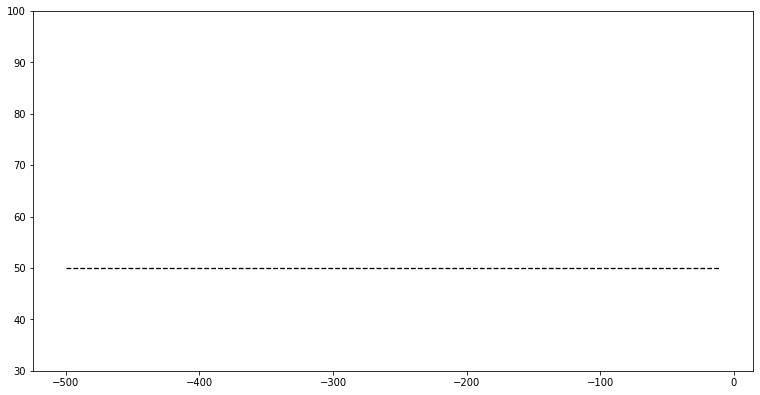

In [410]:
bins = np.arange(window[0], window[-1], 10)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([1,1,1,1])

ax.plot([bins[0], bins[-1]], [50, 50], '--k', lw = 1.3)
plt.ylim([30, 100])

for area in brain_areas:

    currmean = np.mean(task_svm_perf[area], 0)
    currstd = np.std(task_svm_perf[area], 0)

    ax.plot(bins, currmean, color = plot_colors[area],  lw = 3, label = area)
    ax.fill_between(bins, currmean-currstd, currmean+currstd, color = plot_colors[area],  lw = 1., alpha = 0.5, zorder=20)


ax.set_xlabel('Time from sample onset (ms)', fontsize = 20)
ax.set_ylabel('Decoder accuracy (%)', fontsize = 20)
ax.legend(frameon = False, fontsize = 20)

plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(labelsize=20)

#if save_fig:
#    for i in save_filetype:
#        savepath = figpath + 'category_decoding\\' + monkey + '_cat_decoder_count_matched.' + i
#        fig.savefig(savepath, bbox_inches='tight')


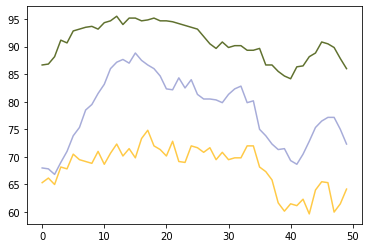

In [328]:
for area in brain_areas:
    plt.plot(np.mean(task_svm_perf[area], 0), color = plot_colors[area])

In [391]:
def task_decoder(data1, data2, n_iter, timepoints, n_neurons_decoder, n_neurons_total, n_trials, k_fold = 4):

    clf = SVC(kernel='linear')

    # Run decoder every 10ms
    n_timepoints = 1#len(timepoints)-1
    decoder_timepoints = timepoints#np.arange(0, n_timepoints, 10)

    # Pre-allocate to save decoder performance
    perf_all = np.zeros([n_iter, len(decoder_timepoints)])

    groups = ['train', 'test']

    n_dirs_decoder = 12
    n_trials_test = int(n_trials/k_fold) * n_dirs_decoder
    n_trials_train = (n_trials - int(n_trials/k_fold)) * n_dirs_decoder

    #n_trials_test = 1
    #n_trials_train = 4


    for iteration in range(n_iter):

            # Choose subset of neurons (if sub-sampling)
            #subsampled_data = sample(all_data, n_neurons_decoder)
            neurons = np.random.choice(n_neurons_total, n_neurons_decoder, replace=False)

            # Pre-allocate training and testing arrays
            svm_data = {}
            svm_data['train'] = [np.zeros([n_neurons_decoder, n_trials_train]) for i in range(n_timepoints)]
            svm_data['test'] = [np.zeros([n_neurons_decoder, n_trials_test]) for i in range(n_timepoints)]

            for i_neuron, neuron in enumerate(neurons):
                pv = np.hstack(data1[neuron])
                dmc = np.hstack(data2[neuron])

                # Organize neuron's data by category and training/testing trials
                X_data, X_data_sorted = {}, {}
                y_data, y_data_sorted = {}, {}

                inds_pv = np.random.choice(len(pv), n_trials_per_dir*12, replace= False)
                inds_dmc = np.random.choice(len(dmc), n_trials_per_dir*12, replace= False)

                Y = np.hstack([np.full(n_trials_per_dir*12, i) for i in range(2)])
                X = np.hstack([[pv[i] for i in inds_pv], [dmc[i] for i in inds_dmc]])

                sss = StratifiedShuffleSplit(n_splits = 1, train_size = n_trials_train, test_size = n_trials_test)
                for train_index, test_index in sss.split(X, Y):
                    X_data['train'], X_data['test'] = X[train_index], X[test_index]
                    y_data['train'], y_data['test'] = Y[train_index], Y[test_index]

                for group in groups:
                    sort = sorted([(e, i) for i, e in enumerate(y_data[group])])
                    y_data_sorted[group] = [i[0] for i in sort]
                    sorted_inds = [i[1] for i in sort]
                    X_data_sorted[group] = X_data[group][sorted_inds]

                    for ii in range(n_timepoints):
                        svm_data[group][ii][i_neuron][:] = X_data_sorted[group][:]# X_data_sorted[group][:, ii]

            # Run decoder
            perf = np.zeros([len(decoder_timepoints)])

            for i_timepoint, timepoint in enumerate(decoder_timepoints):

                clf.fit(svm_data['train'][timepoint].T, y_data_sorted['train'])

                pred = clf.predict(svm_data['test'][timepoint].T)
                perf[i_timepoint] = sum(pred == y_data_sorted['test'])/len(y_data_sorted['test'])*100

                perf_all[iteration] = perf


    return perf_all

In [204]:
5*12

60

In [388]:
timepoints = [0]
data1 = spikes_all['PV']
data2 = spikes_all['DMC']

n_trials = 5
k_fold = 4

n_iter = 50
n_neurons_total = n_neurons_decoder

clf = SVC(kernel='linear')

# Run decoder every 10ms
n_timepoints = 1#len(timepoints)-1
decoder_timepoints = timepoints#np.arange(0, n_timepoints, 10)

# Pre-allocate to save decoder performance
perf_all = np.zeros([n_iter, len(decoder_timepoints)])

groups = ['train', 'test']

n_dirs_decoder = 12
n_trials_test = int(n_trials/k_fold) * n_dirs_decoder
n_trials_train = (n_trials - int(n_trials/k_fold)) * n_dirs_decoder

#n_trials_test = 1
#n_trials_train = 4


for iteration in range(n_iter):

        # Choose subset of neurons (if sub-sampling)
        #subsampled_data = sample(all_data, n_neurons_decoder)
        neurons = np.random.choice(n_neurons_total, n_neurons_decoder, replace=False)

        # Pre-allocate training and testing arrays
        svm_data = {}
        svm_data['train'] = [np.zeros([n_neurons_decoder, n_trials_train]) for i in range(n_timepoints)]
        svm_data['test'] = [np.zeros([n_neurons_decoder, n_trials_test]) for i in range(n_timepoints)]
        
        for i_neuron, neuron in enumerate(neurons):
            pv = np.hstack(data1[neuron])
            dmc = np.hstack(data2[neuron])

            # Organize neuron's data by category and training/testing trials
            X_data, X_data_sorted = {}, {}
            y_data, y_data_sorted = {}, {}

            inds_pv = np.random.choice(len(pv), n_trials_per_dir*12, replace= False)
            inds_dmc = np.random.choice(len(dmc), n_trials_per_dir*12, replace= False)

            Y = np.hstack([np.full(n_trials_per_dir*12, i) for i in range(2)])
            X = np.hstack([[pv[i] for i in inds_pv], [dmc[i] for i in inds_dmc]])

            sss = StratifiedShuffleSplit(n_splits = 1, train_size = n_trials_train, test_size = n_trials_test)
            for train_index, test_index in sss.split(X, Y):
                X_data['train'], X_data['test'] = X[train_index], X[test_index]
                y_data['train'], y_data['test'] = Y[train_index], Y[test_index]

            for group in groups:
                sort = sorted([(e, i) for i, e in enumerate(y_data[group])])
                y_data_sorted[group] = [i[0] for i in sort]
                sorted_inds = [i[1] for i in sort]
                X_data_sorted[group] = X_data[group][sorted_inds]

                for ii in range(n_timepoints):
                    svm_data[group][ii][i_neuron][:] = X_data_sorted[group][:]# X_data_sorted[group][:, ii]

        # Run decoder
        perf = np.zeros([len(decoder_timepoints)])

        for i_timepoint, timepoint in enumerate(decoder_timepoints):

            clf.fit(svm_data['train'][timepoint].T, y_data_sorted['train'])

            pred = clf.predict(svm_data['test'][timepoint].T)
            perf[i_timepoint] = sum(pred == y_data_sorted['test'])/len(y_data_sorted['test'])*100

            perf_all[iteration] = perf


In [389]:
perf_all

array([[100.        ],
       [100.        ],
       [100.        ],
       [ 83.33333333],
       [100.        ],
       [ 91.66666667],
       [ 91.66666667],
       [100.        ],
       [ 91.66666667],
       [100.        ],
       [100.        ],
       [100.        ],
       [ 91.66666667],
       [100.        ],
       [100.        ],
       [100.        ],
       [100.        ],
       [ 75.        ],
       [ 83.33333333],
       [100.        ],
       [100.        ],
       [100.        ],
       [100.        ],
       [100.        ],
       [100.        ],
       [ 91.66666667],
       [100.        ],
       [100.        ],
       [100.        ],
       [ 75.        ],
       [ 91.66666667],
       [100.        ],
       [100.        ],
       [100.        ],
       [ 91.66666667],
       [ 83.33333333],
       [ 75.        ],
       [ 83.33333333],
       [100.        ],
       [100.        ],
       [100.        ],
       [100.        ],
       [100.        ],
       [ 91

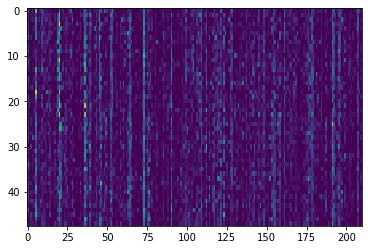

In [390]:
plt.imshow(svm_data['train'][timepoint].T, aspect = 'auto')

In [280]:
y_data['train']

array([ 8, 12, 10,  2, 12, 20, 12, 15, 23, 17, 14,  9, 13, 16,  0, 22,  1,
        4, 22,  8, 15,  5, 15, 17,  2, 13,  1,  2, 16,  8, 16, 17, 20,  4,
       11, 11,  5,  6, 10, 22, 23,  8,  2,  0,  3, 11, 21,  6,  3, 21, 22,
        1,  0,  0,  7, 19,  9, 21,  7, 23,  3,  3,  5, 14, 20, 18, 18, 20,
        4, 19,  9, 14, 12, 13, 19, 10,  7,  6, 21, 23, 18,  4, 11, 17,  6,
       15, 13,  9, 14, 16,  1,  5, 10,  7, 19, 18])

In [443]:
set1 = [[0.779220779, 0.519480519, 0.38961039, 0.25974026, 0.38961039, 0.909090909, 0.779220779, 0.25974026, 0.519480519, 0.649350649], [0.38961039, 0.38961039, 0.12987013, 0.25974026, 0.12987013, 0.38961039, 0, 0.649350649, 0, 0.25974026]]
set2 = [[0.625, 0.938, 0.938, 0.7813, 1.25, 0.4688, 1.4063, 0.313, 0.1563, 0.625], [0.1563, 0.313, 0, 0, 0.1563, 0.1563, 0.1563, 0, 0, 0.1563]]

In [450]:
tmp = [0.666666667, 0.6, 0.75, 0.714285714, 0.888888889, 0.75, 0.818181818, 1, 1, 0.666666667]


In [458]:
tmp2 = [0.666666667, 0.5, 0.6, 0.5, 0.6, 0.583333333, 0.75, 0.153846154, 1, 0.555555556]


In [463]:
tmp3 = [0.333333333, 0.375, 0.2, 0.5, 0.2, 0.25, 0, 0.384615385, 0, 0.222222222]


In [464]:
tmp4 = [0.166666667, 0.2, 0, 0, 0.111111111, 0.25, 0.090909091, 0, 0, 0.166666667]


In [473]:
sp.stats.ttest_ind(tmp[0:5], tmp2[0:5])

Ttest_indResult(statistic=2.592712307441148, pvalue=0.03197799232065123)

(0, 8)

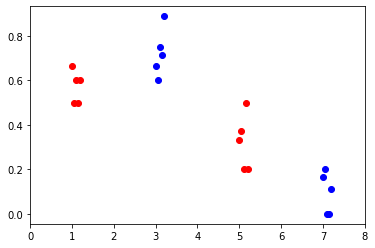

In [474]:
plt.plot(np.arange(1, 1.25, 0.05), tmp2[0:5], 'ro')
plt.plot(np.arange(3, 3.25, 0.05), tmp[0:5], 'bo')

plt.plot(np.arange(5, 5.25, 0.05), tmp3[0:5], 'ro')
plt.plot(np.arange(7, 7.25, 0.05), tmp4[0:5], 'bo')

plt.xlim(0, 8)

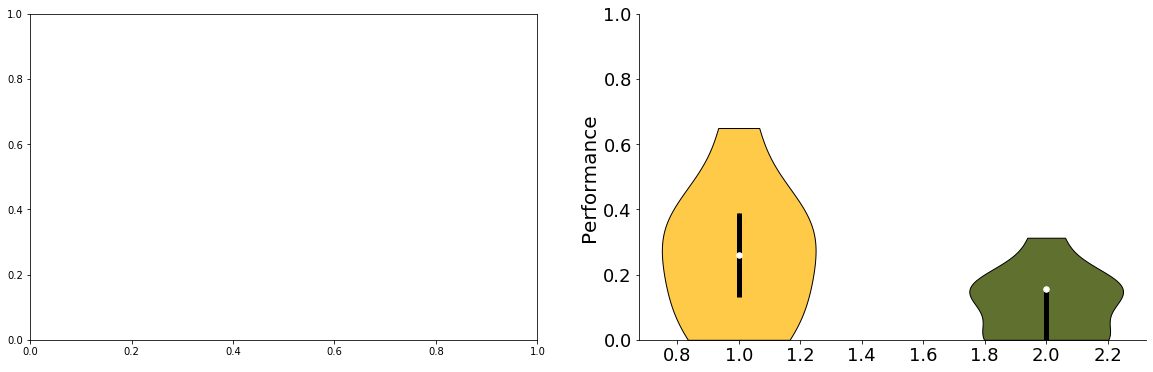

In [449]:
violin_colors = [plot_colors['MT'], plot_colors['MST']]

fig, ax =  plt.subplots(1, 2, figsize=(20, 6))
x1, x2 = 1, 2

for i in range(1, 2):

    data = ([set1[i], set2[i]])

    parts = ax[i].violinplot(data, showmeans=False, showmedians=False, showextrema=False)
    for ii, pc in enumerate(parts['bodies']):
        pc.set_facecolor(violin_colors[ii])
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax[i].scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax[i].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax[i].vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

    #ax[i].set_title(area, fontsize = 25, y = 1.08, fontweight='bold')

    ax[i].tick_params(labelsize = 18)

    ax[i].set_ylim(0, 1)
    #curr_pval = input_data['pvals'][area]
    #sigtext = get_sigtext(curr_pval)

    if abs(np.max(data) + 5)-50 > 5:
        y = np.max(data) + 5
    else:
        y = 55

    h, col = 1.5, 'k'
    ax[i].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    #ax[i][i].text((x1+x2)*.5, y+h, sigtext, ha='center', va='bottom', color=col, fontsize = 20)

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[i][i].set_ylim(0, 0.0016)

    ax[i].set_ylabel('Performance', fontsize = 20)

    #ax[i][0].set_ylim(ylim)
    #ax[i][1].set_ylim(ylim)
    #ax[i][2].set_ylim(ylim)

    # set style for the ax[i]es
    #labels = ['DMC', 'PV']
    #for ax[i] in [ax[i][0], ax[i][1], ax[i][2]]:
    #    set_ax[i]is_style(ax[i], labels)

    plt.show()

    #for i in save_filetype:
        #savename = savepath + i
        #fig.savefig(savename, bbox_inches='tight')

In [219]:
np.std([169, 182, 104, 126])

31.5703579327191

In [221]:
np.std([217, 291, 208, 235])

32.24418552235426

# MDS

In [1033]:
monkey = 'Stanton'

In [1034]:
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler

ord_ind = np.argsort(DIRS)
ord_dirs = [DIRS[i] for i in ord_ind]

In [1035]:
window = windows[0]
window_name = 'window_' + str(window[0]) + '_' + str(window[-1])
timepoints = np.arange(np.where(window == 250)[0][0], np.where(window == 400)[0][0])

for area in brain_areas[3:4]:
    
    if monkey != 'both':
        if exclude_stim1:  
            currpath = datapathsave + monkey + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
        else:
            currpath = datapathsave + monkey + '\\' + area + '\\stim1_included\\' + window_name + '\\'

        os.chdir(currpath)
        filelist = [f for f in glob.glob("*.mat")]  
    else:
        if exclude_stim1:  
            currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
            currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_excluded\\' + window_name + '\\'
        else:
            currpath1 = datapathsave + 'Neville' + '\\' + area + '\\stim1_included\\' + window_name + '\\'
            currpath2 = datapathsave + 'Stanton' + '\\' + area + '\\stim1_included\\' + window_name + '\\'

        os.chdir(currpath1)
        filelist1 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        os.chdir(currpath2)
        filelist2 = [os.path.abspath(f) for f in glob.glob("*.mat")]  
        
        filelist = np.hstack([filelist1, filelist2])
        
    spikes_all = {}
    spikes_all['PV'], spikes_all['DMC'] = [[] for i in range(N_DIRS)], [[] for i in range(N_DIRS)]

    for file in filelist:
        data = sio.loadmat(file)
        
        spikes_pv = data['spikes_binned_pv'].flatten()*10
        spikes_dmc = data['spikes_binned_dmc'].flatten()*10
        
        dmc = [np.mean(i[:, timepoints]) for i in spikes_dmc]
        pv = [np.mean(i[:, timepoints]) for i in spikes_pv]
        
        zscored = stats.zscore(np.hstack([pv, dmc]))
        
        #for ii in (ord_ind):
        #    spikes_all['PV'][ii].append(zscored[ii])
        #    spikes_all['DMC'][ii].append(zscored[ii+12])        
        
        for ii in ord_ind:
            spikes_all['PV'][ii].append(np.mean(np.mean(spikes_pv[ii][:, timepoints], 1)))
            spikes_all['DMC'][ii].append(np.mean(np.mean(spikes_dmc[ii][:, timepoints], 1)))



In [1036]:
ord_ind = np.argsort(DIRS)
ord_dirs = [DIRS[i] for i in ord_ind]

In [1037]:
ord_ind

array([ 5,  4,  3,  8,  7,  6,  2,  1,  0, 11, 10,  9], dtype=int64)

<IPython.core.display.Javascript object>


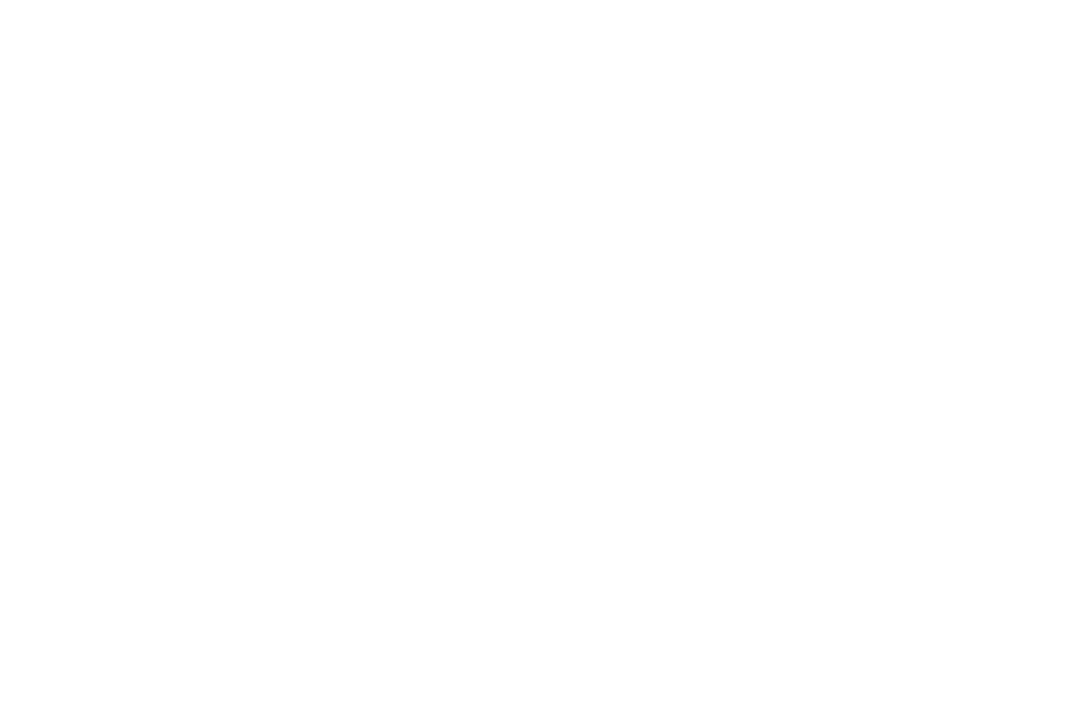

<IPython.core.display.Javascript object>


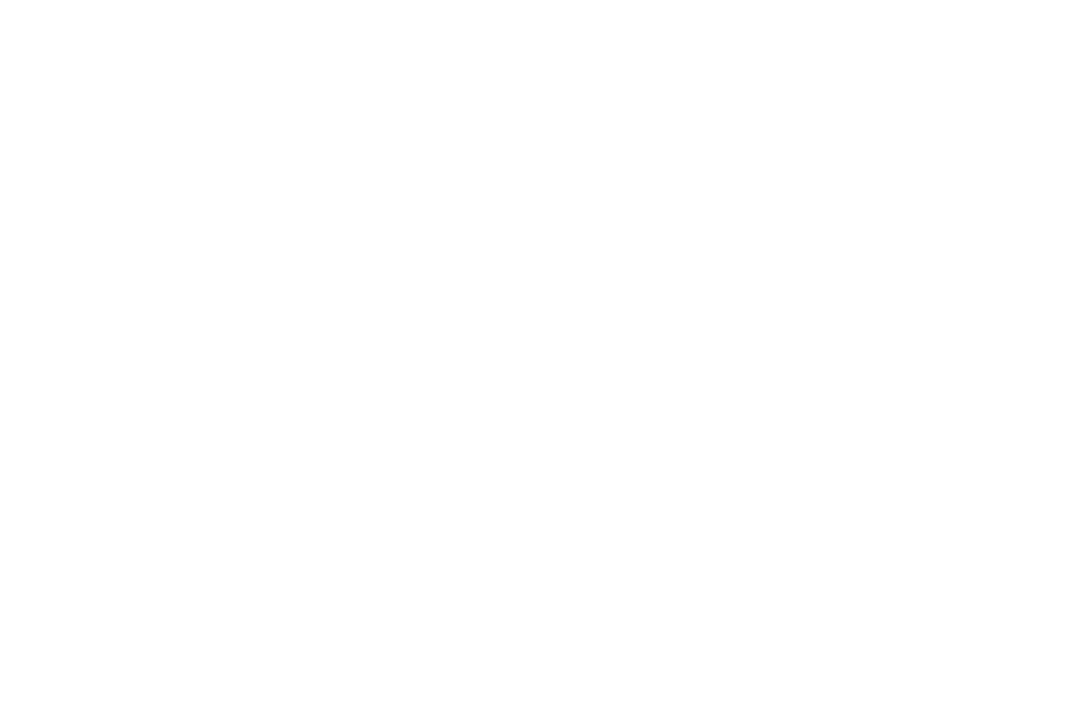

In [1055]:
%matplotlib notebook


all_data = (np.vstack([spikes_all['PV'], spikes_all['DMC']]))
mds = MDS(3, random_state=0)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(all_data)
#X_2d = mds.fit_transform(X_scaled)
X_2d = mds.fit_transform(all_data)

fig, ax =  plt.subplots(1, 2, figsize=(15, 10))
ax = plt.axes(projection='3d')

for i in range(3):
    ax.scatter(X_2d[i][0], X_2d[i][1], X_2d[i][2], marker = '^', edgecolor = 'darkslategrey', facecolor = plot_colors['Category1'], s = 80)

for i in range(3, 6):
    ax.scatter(X_2d[i][0], X_2d[i][1], X_2d[i][2], marker = 'o', edgecolor = 'darkslategrey', facecolor = plot_colors['Category1'], s = 80)

for i in range(6, 9):
    ax.scatter(X_2d[i][0], X_2d[i][1], X_2d[i][2], marker = '^', edgecolor = 'darkslategrey', facecolor = plot_colors['Category2'], s = 80)

for i in range(9, 12):
    ax.scatter(X_2d[i][0], X_2d[i][1], X_2d[i][2], marker = 'o', edgecolor = 'darkslategrey', facecolor = plot_colors['Category2'], s = 80) 

    
for i in range(3):
    ax.scatter(X_2d[i+12][0], X_2d[i+12][1], X_2d[i+12][2], marker = '^', edgecolor = 'darkslategrey', facecolor = 'b', s = 80)

for i in range(3, 6):
    ax.scatter(X_2d[i+12][0], X_2d[i+12][1], X_2d[i+12][2], marker = 'o', edgecolor = 'darkslategrey', facecolor = 'b', s = 80)

for i in range(6, 9):
    ax.scatter(X_2d[i+12][0], X_2d[i+12][1], X_2d[i+12][2], marker = '^', edgecolor = 'darkslategrey', facecolor = 'r', s = 80)

for i in range(9, 12):
    ax.scatter(X_2d[i+12][0], X_2d[i+12][1], X_2d[i+12][2], marker = 'o', edgecolor = 'darkslategrey', facecolor = 'r', s = 80) 


plt.show()

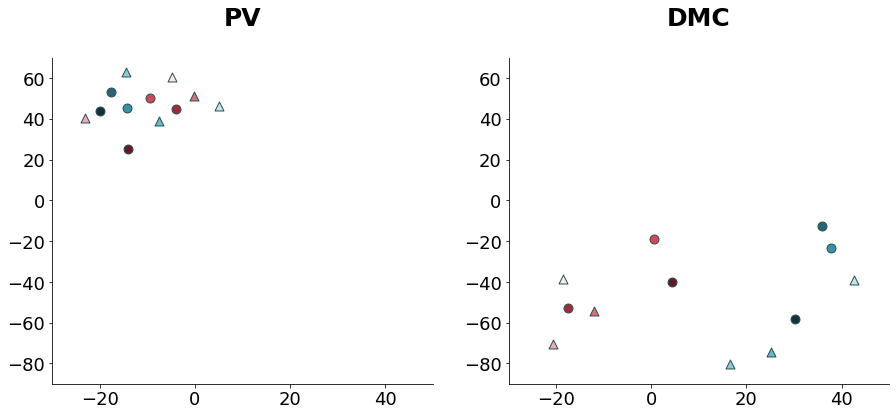

In [1056]:
%matplotlib inline

cat1_colors =  ['#c6e5ec', '#8ccbd9', '#66b9cc', '#3891a6', '#266573', '#133239']
cat2_colors =  ['#faeaec', '#ebadb4', '#dc6f7c', '#d24657', '#a42836', '#671922']



all_data = (np.vstack([spikes_all['PV'], spikes_all['DMC']]))
mds = MDS(2, random_state=0)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(all_data)
#X_2d = mds.fit_transform(X_scaled)
X_2d = mds.fit_transform(all_data)

fig, ax =  plt.subplots(1, 2, figsize=(15, 6))

for i in range(3):
    ax[0].scatter(X_2d[i][0], X_2d[i][1], marker = '^', edgecolor = 'darkslategrey', facecolor = cat1_colors[i], s = 80)

for i in range(3, 6):
    ax[0].scatter(X_2d[i][0], X_2d[i][1], marker = 'o', edgecolor = 'darkslategrey', facecolor = cat1_colors[i], s = 80)

for i in range(6, 9):
    ax[0].scatter(X_2d[i][0], X_2d[i][1], marker = '^', edgecolor = 'darkslategrey', facecolor = cat2_colors[i-6], s = 80)

for i in range(9, 12):
    ax[0].scatter(X_2d[i][0], X_2d[i][1], marker = 'o', edgecolor = 'darkslategrey', facecolor = cat2_colors[i-6], s = 80) 

    
for i in range(3):
    ax[1].scatter(X_2d[i+12][0], X_2d[i+12][1], marker = '^', edgecolor = 'darkslategrey', facecolor = cat1_colors[i], s = 80)

for i in range(3, 6):
    ax[1].scatter(X_2d[i+12][0], X_2d[i+12][1], marker = 'o', edgecolor = 'darkslategrey', facecolor = cat1_colors[i], s = 80)

for i in range(6, 9):
    ax[1].scatter(X_2d[i+12][0], X_2d[i+12][1], marker = '^', edgecolor = 'darkslategrey', facecolor = cat2_colors[i-6], s = 80)

for i in range(9, 12):
    ax[1].scatter(X_2d[i+12][0], X_2d[i+12][1], marker = 'o', edgecolor = 'darkslategrey', facecolor = cat2_colors[i-6], s = 80) 

#ax[1].scatter(X_2d[2+12][0], X_2d[2+12][1], marker = '^', edgecolor = 'darkslategrey', facecolor = plot_colors['Category1'], s = 180) 
#ax[1].scatter(X_2d[6+12][0], X_2d[6+12][1], marker = '^', edgecolor = 'darkslategrey', facecolor = plot_colors['Category2'], s = 180) 
#ax[1].scatter(X_2d[5+12][0], X_2d[5+12][1], marker = 'o', edgecolor = 'darkslategrey', facecolor = plot_colors['Category1'], s = 180) 
    
for i_task, task in enumerate(tasks):
    
    ax[i_task].set_xlim(int(np.floor(min([i[0] for i in X_2d])/5.0)*5.0)-5, int(np.ceil(max([i[0] for i in X_2d])/5.0)*5.0)+5)
    ax[i_task].set_ylim(int(np.floor(min([i[1] for i in X_2d])/5.0)*5.0)-5, int(np.ceil(max([i[1] for i in X_2d])/5.0)*5.0)+5)

    #ax[i_task].set_xlim(-100, 90)
    #ax[i_task].set_ylim(-120, 130)
    
    ax[i_task].set_title(task, y = 1.08, fontsize = 25, fontweight='bold')
    ax[i_task].spines['right'].set_visible(False)
    ax[i_task].spines['top'].set_visible(False)
    ax[i_task].tick_params(labelsize = 18)
    
    
for i in save_filetype:
    savepath = figpath + 'mds\\' + monkey + '_' + area + '_pv_dmc_mds_together_3d.' + i
    #fig.savefig(savepath, bbox_inches='tight')


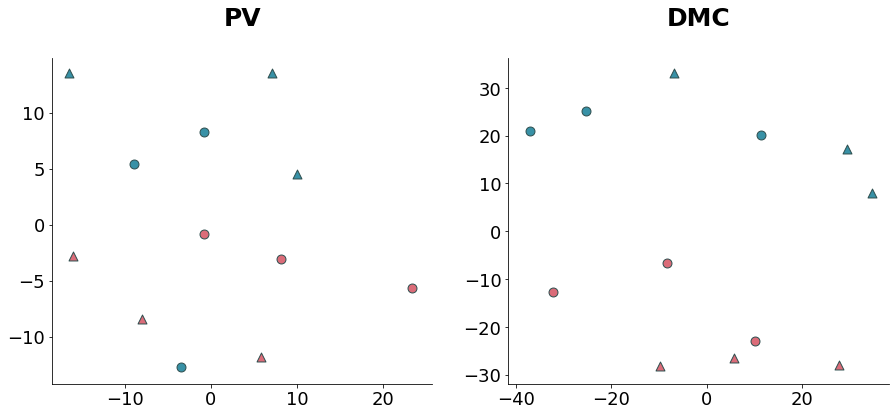

In [1040]:
fig, ax =  plt.subplots(1, 2, figsize=(15, 6))

for i_task, task in enumerate(tasks):
    
    mds = MDS(2, random_state=0)
    X_2d = mds.fit_transform(spikes_all[task])

    for i in range(3):
        ax[i_task].scatter(X_2d[i][0], X_2d[i][1], marker = '^', edgecolor = 'darkslategrey', facecolor = plot_colors['Category1'], s = 80)

    for i in range(3, 6):
        ax[i_task].scatter(X_2d[i][0], X_2d[i][1], marker = 'o', edgecolor = 'darkslategrey', facecolor = plot_colors['Category1'], s = 80)

    for i in range(6, 9):
        ax[i_task].scatter(X_2d[i][0], X_2d[i][1], marker = '^', edgecolor = 'darkslategrey', facecolor = plot_colors['Category2'], s = 80)

    for i in range(9, 12):
        ax[i_task].scatter(X_2d[i][0], X_2d[i][1], marker = 'o', edgecolor = 'darkslategrey', facecolor = plot_colors['Category2'], s = 80) 
        
        
    ax[i_task].set_title(task, y = 1.08, fontsize = 25, fontweight='bold')
    ax[i_task].spines['right'].set_visible(False)
    ax[i_task].spines['top'].set_visible(False)
    ax[i_task].tick_params(labelsize = 18)
    
    #ax[i_task].set_xlim(-25, 35)
    #ax[i_task].set_ylim(-20, 25)
    
    #ax[i_task].set_xlim(int(np.floor(min([i[0] for i in X_2d])/5.0)*5.0)-5, int(np.ceil(max([i[0] for i in X_2d])/5.0)*5.0)+5)
    #ax[i_task].set_ylim(int(np.floor(min([i[1] for i in X_2d])/5.0)*5.0)-5, int(np.ceil(max([i[1] for i in X_2d])/5.0)*5.0)+5)
    
    
for i in save_filetype:
    savepath = figpath + 'mds\\' + monkey + '_' + area + '_pv_dmc_mds.' + i
    f#ig.savefig(savepath, bbox_inches='tight')

    

In [396]:
savepath

'E:\\two_boundary\\figures\\passive_viewing\\mds\\Stanton_LIP_pv_dmc_mds.pdf'